In [1]:
from sage.topology.simplicial_set import AbstractSimplex, SimplicialSet
from sage.topology.simplicial_set_morphism import SimplicialSetMorphism
from itertools import product
from math import prod
import numpy

For the later use we implement a function that returns a group presentation of the fundamental group of a connected simplicial set $X$ together with a list $gens =[e_0,\dots, e_m]$. The $e_i$ are non-degenerate $1$-simplices in $X$. Moreover, $X_1^\text{nd}\setminus \{e_1,\dots, e_m\}$ is the collection of edges of a spanning tree in the $1$-skeleton of $X$. The computed group presentation will have generators $e_1,\dots, e_m$. 

Such an algorithm already exists in SageMath and we just modify it slightly.

In [2]:
# this is a modification of code under the following Copyright
#*****************************************************************************
#  Copyright (C) 2015 John H. Palmieri <palmieri at math.washington.edu>
#
#  Distributed under the terms of the GNU General Public License (GPL)
#                  http://www.gnu.org/licenses/
#******************************************************************************

def fundamental_group_w_gens(X):
    if len(X.f_vector())<2:
        return FreeGroup(0)/[], []
    if not X.is_connected():
        raise ValueError("the given simplicial set is not connected")
    graph = X.graph() #graph with edges the non-degenerate 1-cells
    edges = [e[2] for e in graph.edges()]
    spanning_tree = [e[2] for e in graph.min_spanning_tree()]
    gens = [e for e in edges if e not in spanning_tree]
    if gens == []:
        return FreeGroup(0)/[], []
    FG = FreeGroup(len(gens), 'e')
    rels = []
    #adding the reltations given by the 2-cells
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in spanning_tree:
                z[i]=FG.one()
            else: 
                z[i]=FG.gen(gens.index(e))
        rels.append(z[0]*z[1].inverse()*z[2])
    return FG.quotient(rels), gens

# Normal Covering Spaces

## Chain Complex of normal covering 

The following algorithm should implement part 2 of algorithm (3) from the enclosed bachelor thesis. The function is not meant to be directly called but will be used by later functions. 

In [3]:
def complexOfCover(X, G, gens, Simplification = False):
    
    if not X.is_finite():
        raise ValueError("the given simplicial set might not be finite")
    f_vec = X.f_vector()
    if len(f_vec)<2:
        return X.chain_complex()

    if Simplification:
        h = G.simplification_isomorphism()
        G_simp = h.codomain()
        R = G_simp.algebra(ZZ)
    else: 
        R = G.algebra(ZZ)
        
    deckTrnsf = {i: [] for i in range(1, len(f_vec))} 
    bdryComplx = {}
    for i in range(1, len(f_vec)):
        bdryComplx[i] = matrix(R, f_vec[i-1], f_vec[i])
                                        
    for j in range(f_vec[1]):
        e = X.n_cells(1)[j]
        ind_d0 = X.n_cells(0).index(X.face(e,0))
        ind_d1 = X.n_cells(0).index(X.face(e,1))
        bdryComplx[1][ind_d1,j] -= 1 
        if e in gens:
            if Simplification:
                e_titz = h(G.gen(gens.index(e))).Tietze()
                e_simp = G_simp.one()
                for m in range(len(e_titz)):
                    e_simp = e_simp*G_simp.gen(abs(e_titz[m])-1)^(sgn(e_titz[m]))
                bdryComplx[1][ind_d0,j] += e_simp*R.one()
                deckTrnsf[1].append(e_simp*R.one())
            else:
                bdryComplx[1][ind_d0,j] += R.algebra_generators()[gens.index(e)]
                deckTrnsf[1].append(R.algebra_generators()[gens.index(e)])
        else:
            bdryComplx[1][ind_d0,j] += 1
            deckTrnsf[1].append(1)
    
    for n in range(2, len(f_vec)):
        for j in range(f_vec[n]):
            f = X.n_cells(n)[j]
            for m in range(1, n+1):
                if X.face(f,m).is_nondegenerate():
                    bdryComplx[n][X.n_cells(n-1).index(X.face(f,m)),j] += (-1)^m
            dn = X.face(f,n)
            if dn.is_degenerate() and 0 in dn.degeneracies():
                if X.face(f,0).is_nondegenerate():
                    bdryComplx[n][X.n_cells(n-1).index(X.face(f,0)),j] += 1
                deckTrnsf[n].append(R.one())
            else: 
                dim_und = dn.nondegenerate().dimension()
                ind_und = X.n_cells(dim_und).index(dn.nondegenerate())
                if X.face(f,0).is_nondegenerate():
                    i = X.n_cells(n-1).index(X.face(f,0))
                    bdryComplx[n][i,j] += deckTrnsf[dim_und][ind_und]
                deckTrnsf[n].append(deckTrnsf[dim_und][ind_und])
                
    return bdryComplx

### Variant 1: User has to compute spanning tree

The next function implements algorithm (3) in the unmodified version from the bachelor thesis. 

This version of the algorithm requires the user to give a finite simplicial set $X$ together with edges $e_1,\dots, e_m \in X_1^{\text{nd}}$ contained in a list $gens=[e_1,\dots, e_m]$ such that $X_1^{\text{nd}}\setminus \{e_1,\dots, e_m\}$ form the edges in a spanning tree of the $1$-skeleton of $X$. Whether this is satisfied, is checked by the following implementation. Further, the user needs to provide a list $N$ of elements in the free group $F(\{e_1,\dots, e_m\})$. 

The algorithm computes the normalized chain complex $C$ of a covering space $Z$ of $X$, such that $Z$ has fundamental group equal to the normal subgroup of $\pi_1(X)$ generated by the elements in $N$. We will denote the quotient of $\pi_1(X)$ by this subgroup by $G$. $C$ is a chain complex of free $\mathbb{Z}[G]$-modules, where lifts of the nondegenerate $k$-simplices of $X$ form a $\mathbb{Z}[G]$-basis of $C_k$.

Firstly, the function computes a presentation of $G$ such that the $e_1,\dots, e_m$ are the generators. 

Then, the function returns $C$ by giving the matrices of the boundary operators with respect to a $\mathbb{Z}[G]$-basis of every $C_k$, where the basis of $C_k$ consists of lifts of nondegenerate $k$-simplices of $X$.

If the function is called with the boolean simplification set to True, then GAP is asked to simplify the computed presentation of $G$.

In [4]:
def complexOfNormalCoveringTree(X, gens, N, Simplification=False):
    
    #X the simplicial set,
    #gens the list of edges not in spanning tree,
    #N relations in the free group F(gens)
    
    if X.dimension()<1:
        return X.chain_complex() 
    if not X.is_connected():
        raise ValueError("given simplicial set not connected")
        
    #next we check wether sk_1(X)-gens is a spanning tree in sk_1(X)
    treeSimplices = {}
    for e in [item for item in X.n_cells(1) if item not in gens]:
        treeSimplices[e]=(X.face(e,0), X.face(e,1))
    for v in X.n_cells(0):
        treeSimplices[v]=None
    tree = SimplicialSet(treeSimplices)
    if not tree.is_connected():
        raise ValueError("sk_1(X)-gens not spanning subgraph of sk_1(X)")
    if not tree.is_acyclic():
        raise ValueError("sk_1(X)-gens is not acyclic")
    if N == []: 
        FG = FreeGroup(len(gens), 'e')
    else: 
        if not len(N[0].parent().generators())==len(gens):
            raise ValueError("N not subset of free group on gens")
        FG = N[0].parent()
        for i in range(len(N)):
            if not N[i].parent()==FG:
                raise ValueError("N not subset of one group")
                
    #now we compute a presentation of pi_1(X)/N
    rels = []
    #adding the relations given by the 2-cells of X
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in gens:
                z[i]=FG.gen(gens.index(e))
            else: 
                z[i]=FG.one()
        rels.append(z[0]*z[1].inverse()*z[2])
    G = FG.quotient(rels+N)
    
    return complexOfCover(X, G, gens, Simplification)

#### Small Examples:

We may compute the chain complex of a double cover of the circle, where we define the circle $S^1$ to be the simplicial set which has only two nondegenerate simplices, one of them being a one-simplex.

In [5]:
s1=simplicial_sets.Sphere(1)
FG=FreeGroup(1); 
gens = s1.n_cells(1)
N = [FG.gen(0)^2]
C_S1_double = complexOfNormalCoveringTree(s1, gens, N)
C_S1_double, C_S1_double[1].base_ring()

({1: [-1 + x]},
 Algebra of Finitely presented group < x | x^2 > over Integer Ring)

Now we compute the chain complex  of double cover of the torus.

We use a triangulation of the torus as $\Delta$-complex with two $2$-simplices.

In [6]:
t= simplicial_sets.Torus()
FG=FreeGroup(len(t.n_cells(1)), 'a')
gens = t.n_cells(1)
N = [FG.gen(0)^2, FG.gen(1)]
C_double_torus = complexOfNormalCoveringTree(t, gens, N, True)
C_double_torus[1].base_ring()

Algebra of Finitely presented group < a0 | a0^2 > over Integer Ring

We print the computed result "C_double_torus" in latex:
$$\left\{1 :\; \left(\begin{array}{rrr}
-1 + a_{0} & 0 & -1 + a_{0}
\end{array}\right),\quad  2 :\; \left(\begin{array}{rr}
1 & 1 \\
a_{0} & 1 \\
-1 & -1
\end{array}\right)\right\}$$

### Variant 2: User gives the normal subgroup by loops

Next we implement algorithm (3) from the enclosed bachelor thesis in the version modified by algorithm (4). 

So, the function has input $X$, a finite connected simplicial set, and $N$, where $N$ is a list of lists, $N=[n_0, \dots, n_s]$.

Each $n_i$ is a list of tuples $(\sigma_{i_1}, k_{i_1}),\dots, (\sigma_{i_{r_i}}, k_{r_i})$ for each $\sigma_{i_j}$ a nondegenerate $1$-simplex of $X$ and $k_{i_j}\in \mathbb{Z}$ such that $\sigma_{i_1}^{k_{i_1}}*\dots*\sigma_{i_{r_i}}^{k_{r_i}}$ is forming a loop in the 1-skeleton of $X$. 

The condition that $n_i$ defines a loop says that  

$$\text{for all $j=1,\dots, r_i$ } \quad  \begin{cases}
    d_0(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}, k_{i_{j+1  \text{ mod } r_i}}>0\\
    d_0(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}>0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}<0\\
    d_1(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}<0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}>0\\
    d_1(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}, k_{i_{j+1 \text{ mod } r_i}}<0.
\end{cases}
$$ 
and $d_0(\sigma_{i_j})=d_1(\sigma_{i_j})$ if $|k_{i_j}|>1$.

The algorithm computes the normalized chain complex $C$ of a covering space $Z$ of $X$, such that $Z$ has fundamental group equal to the normal subgroup of $\pi_1(X)$ generated by the elements in $N$. We will denote the quotient of $\pi_1(X)$ by this subgroup by $G$. $C$ is a chain complex of free $\mathbb{Z}[G]$-modules, where lifts of the nondegenerate $k$-simplices of $X$ form a $\mathbb{Z}[G]$ basis of $C_k$.

The function computes a presentation of $G$ and returns $C$ by giving the matrices of the boundary operators with respect to a $\mathbb{Z}[G]$-basis of every $C_k$, where the basis of $C_k$ consists of lifts of nondegenerate $k$-simplices of $X$.

If the function is called with the boolean Simplification set to True, then GAP is asked to simplify the computed presentation of $G$.

If the function is called with the boolean check set to True, then it is check whether $N$ is of the above form.

In [7]:
def complexOfNormalCoveringLoops(X, N, Simplification=False, check=True):
    
    #X a finite connected simplicial set, 
    #N loops in the 1-skeleton of X given in the above form
    
    if X.dimension()<1:
        return X.chain_complex() 
    if not X.is_connected():
        raise ValueError("given simplicial set not connected")
        
    #We  check whether N is of the required form: 
    if check:
        for n in N:
            for j in range(len(n)):
                s,k = n[j]
                s1, k1 = n[(j+1)%len(n)]
                if abs(k)>1 and X.face(s, 0)!=X.face(s, 1):
                    raise ValueError("N doens't consist of loops")
                if k>0 and k1>0 and X.face(s, 0) != X.face(s1, 1):
                    raise ValueError("N doens't consist of loops")
                if k>0 and k1<0 and X.face(s, 0) != X.face(s1, 0):
                    raise ValueError("N doens't consist of loops")
                if k<0 and k1>0 and X.face(s, 1)!= X.face(s1, 1):
                    raise ValueError("N doens't consist of loops")
                if k<0 and k1<0 and X.face(s, 1)!= X.face(s1, 0):
                    raise ValueError("N doens't consist of loops")
                      
    # let us compute a presentation of the fundamental group G of X
    graph = X.graph() #graph with edges the non-degenerate 1-cells
    edges = [e[2] for e in graph.edges()]
    spanning_tree = [e[2] for e in graph.min_spanning_tree()]
    gens = [e for e in edges if e not in spanning_tree]
    FG = FreeGroup(len(gens), 'e')
    rels = []
    #adding the relations given by the 2-cells
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in spanning_tree:
                z[i]=FG.one()
            else: 
                z[i]=FG.gen(gens.index(e))
        rels.append(z[0]*z[1].inverse()*z[2])
    
    # presentation of normal subgroup of pi_1(X) generated by N
    N_pr = []
    for n in N:
        n_pr=FG.one()
        for e,k in n:
            if e in gens:
                n_pr=n_pr*FG.gen(gens.index(e))^k
        N_pr.append(n_pr)
    
    G = FG.quotient(rels+N_pr)
    
    return complexOfCover(X, G, gens, Simplification)

#### Small Examples

We use a triangulation of the torus as $\Delta$-complex with two $2$-simplices.

In [8]:
torus = simplicial_sets.Torus()

In [9]:
N=[[(torus.n_cells(1)[2], 2)]]
N.append([(torus.n_cells(1)[2], -1)]) 
N.append([(torus.n_cells(1)[0], -3), (torus.n_cells(1)[1], 1)])

In [10]:
C_torus_N = complexOfNormalCoveringLoops(torus, N, Simplification=True)
C_torus_N[1].base_ring()

Algebra of Finitely presented group < e0 | e0^4 > over Integer Ring

We have computed the chain complex of a 4-sheeted covering with deck-transformation group $\mathbb{Z}/4\mathbb{Z}$. 

We print "C_torus_N" in latex:

$$\left\{1 : \;\left(\begin{array}{rrr}
-1 + e_{0} & -1 + e_{0}^{-1} & 0
\end{array}\right), \quad 2 :\; \left(\begin{array}{rr}
1 & e_{0}^{-1} \\
e_{0} & 1 \\
-1 & -1
\end{array}\right)\right\}$$

### Variant 3: Chain complex of the universal cover

Computing the normalized chain complex of the universal cover of $X$ as free $\mathbb{Z}[\pi_1(X)]$-module chain complex with basis given by lifts of nondegenerate simplices of $X$ corresponds to computing a normal covering space using the function "complexOfNormalCoveringLoops" and setting $N=0$ as input. 

In [11]:
def complexOfUniversalCover(X, simplify_group=False):
    return complexOfNormalCoveringLoops(X, [], simplify_group, check=False)

#### Examples

We use a triangulation of the torus as $\Delta$-complex with two $2$-simplices.

In [12]:
torus = simplicial_sets.Torus()
C_torus = complexOfUniversalCover(torus, simplify_group=True)
C_torus[1].base_ring()

Algebra of Finitely presented group < e0, e1 | e0*e1^-1*e0^-1*e1 > over Integer Ring

We print "C_torus" by using the function latex(C_torus):

$$\left\{1 :\; \left(\begin{array}{rrr}
-1 + e_{0} & -1 + e_{1} & -1 + e_{0}\cdot e_{1}
\end{array}\right), \quad2 :\; \left(\begin{array}{rr}
1 & e_{1} \\
e_{0} & 1 \\
-1 & -1
\end{array}\right)\right\}$$

Next we use a triangulation of the Klein Bottle as $\Delta$-complex with two $2$-simplices.

In [13]:
kleinBottle = simplicial_sets.KleinBottle();
C_kleinBottle= complexOfUniversalCover(kleinBottle, True)
C_kleinBottle[1].base_ring()

Algebra of Finitely presented group < e0, e1 | e0*e1^-1*e0*e1 > over Integer Ring

Printing the computed chain complex of the universal cover of the Klein bottle in LaTeX gives:

$$\left\{1 :\; \left(\begin{array}{rrr}
-1 + e_{0} & -1 + e_{1} & -1 + e_{0}\cdot e_{1}
\end{array}\right), \quad 2 :\; \left(\begin{array}{rr}
1 & e_{0}\cdot e_{1} \\
e_{0} & -1 \\
-1 & 1
\end{array}\right)\right\}$$

Let us try a random simplicial complex of dimension 4 with 11 vertices.

In [14]:
RdCom =SimplicialSet(simplicial_complexes.RandomComplex(11,4))
RdCom.is_connected()

True

In [15]:
complexOfUniversalCover(RdCom, simplify_group=True)

{1: 11 x 55 dense matrix over Algebra of Finitely presented group <  |  > over Integer Ring,
 2: 55 x 165 dense matrix over Algebra of Finitely presented group <  |  > over Integer Ring,
 3: 165 x 330 dense matrix over Algebra of Finitely presented group <  |  > over Integer Ring,
 4: 330 x 226 dense matrix over Algebra of Finitely presented group <  |  > over Integer Ring}

RdCom is simply-connected and so we just computed its normalized chain complex 

Next we try a triangulation of the Poincaré homology $3$-sphere triangulated as simplicial complex.

In [16]:
P_S3 = SimplicialSet(simplicial_complexes.PoincareHomologyThreeSphere())

In [17]:
complexOfUniversalCover(P_S3, simplify_group=True) 

{1: 16 x 106 dense matrix over Algebra of Finitely presented group < e2, e5 | e2*e5^-1*e2^-1*e5^-1*e2*e5, e5^-1*e2*e5*e2^-1*e5*e2*e5^-1 > over Integer Ring,
 2: 106 x 180 dense matrix over Algebra of Finitely presented group < e2, e5 | e2*e5^-1*e2^-1*e5^-1*e2*e5, e5^-1*e2*e5*e2^-1*e5*e2*e5^-1 > over Integer Ring,
 3: 180 x 90 dense matrix over Algebra of Finitely presented group < e2, e5 | e2*e5^-1*e2^-1*e5^-1*e2*e5, e5^-1*e2*e5*e2^-1*e5*e2*e5^-1 > over Integer Ring}

## Construction of normal covering space 

The following algorithm is an implementation of part 2 of algorithm (2) given in the enclosed bachelor thesis. The following function is not meant to be directly called but will be used in later functions.

In [21]:
def ConstructionCoveringSpace(X, G, gens):
    if not X.is_finite():
        raise ValueError("given simplicial set might not be finite")
    f_vec = X.f_vector()
    if len(f_vec)<2:
        return X
    G_list = G.list()
    card = len(G_list)
    
    simp = {n: dict() for n in range(len(f_vec))}
    deckTrnsf = {n: [] for n in range(1, len(f_vec))} 
    for n in range(len(f_vec)):
        for s in X.n_cells(n):
            simp[n][s]=[AbstractSimplex(n, name = str(G_list[i])+str(s)) for i in range(card)]
    sSet = dict() # the simplicial covering space
    f =dict() #the simplicial covering map 
    for v in X.n_cells(0):
        for i in range(card):
            sSet[simp[0][v][i]]= None
            f[simp[0][v][i]] = v
    for e in X.n_cells(1):
        d0 = X.face(e,0); d1 = X.face(e,1)
        if e in gens: 
            for i in range(card):
                ie = G_list.index(G_list[i]*G.gen(gens.index(e)))
                sSet[simp[1][e][i]]=( simp[0][d0][ie], simp[0][d1][i])
                f[simp[1][e][i]]= e
            deckTrnsf[1].append(G.gen(gens.index(e))) 
        else: 
            for i in range(card):
                sSet[simp[1][e][i]]=(simp[0][d0][i], simp[0][d1][i])
                f[simp[1][e][i]]= e
            deckTrnsf[1].append(1)
    for n in range(2, len(f_vec)):
        for s in X.n_cells(n):
            faces = [X.face(s,i).nondegenerate() for i in range(0, n+1)]
            dimns = [faces[i].dimension() for i in range(0,n+1)]
            degens = [X.face(s,i).degeneracies() for i in range(0, n+1)]
            g0 = G.one()
            if degens[n]==[] or min(degens[n])>0:
                g0 = deckTrnsf[dimns[n]][X.n_cells(dimns[n]).index(faces[n])]
            deckTrnsf[n].append(g0)
            for i in range(card):
                ig0 = G_list.index(G_list[i]*g0)
                d0_i_s = simp[dimns[0]][faces[0]][ig0]
                d0_i_s = d0_i_s.apply_degeneracies(*degens[0])
                faces_i_s = [d0_i_s]
                for j in range(1,n+1):
                    dj_i_s = simp[dimns[j]][faces[j]][i]
                    dj_i_s = dj_i_s.apply_degeneracies(*degens[j])
                    faces_i_s.append(dj_i_s)
                sSet[simp[n][s][i]]=tuple(faces_i_s)
                f[simp[n][s][i]]= s
    Z = SimplicialSet(sSet)
    f = SimplicialSetMorphism(f, Z, X)
    return f

A small test for the universal cover of simplicial set that is not a $\Delta$-complex.

In [19]:
S2 = simplicial_sets.Sphere(2)
RP2 = simplicial_sets.RealProjectiveSpace(2)
S2xRP2 = S2.product(RP2)
G, gens = fundamental_group_w_gens(S2xRP2)

The universal cover of $S^2\times \mathbb{R}P^2$ is $S^2\times S^2$. By the Künneth theorem it has the following reduced homology:

In [22]:
ConstructionCoveringSpace(S2xRP2, G,gens).domain().homology()

{0: 0, 1: 0, 2: Z x Z, 3: 0, 4: Z}

### Variant 1: User has to compute spanning tree

The next function implements algorithm (2) in the unmodified version from the bachelor thesis. 

This version of the algorithm requires the user to give a finite simplicial set $X$ together with edges $e_1,\dots, e_m \in X_1^{\text{nd}}$ contained in a list $gens=[e_1,\dots, e_m]$ such that $X_1^{\text{nd}}\setminus \{e_1,\dots, e_m\}$ form the edges of a spanning tree in the $1$-skeleton of $X$. Whether this is satisfied, is checked by the following implementation. 

Further, the function has as input a list $N$ of elements in the free group $F(\{e_1,\dots, e_m\})$, such that the quotient of $F(\{e_1,\dots, e_m\})$ by $N$ union relations in $\pi_1(X)$ is a finite group $G$.

The algorithm returns a morphism of simplicial sets $f: Z \to X$ such that $f$ is a covering projection and $f_*(\pi_1(Z))$ is the normal subgroup of $\pi_1(X)$ generated by the elements in $N$. Further, $Z$ is a finite, connected simplicial set.

In [23]:
def NormalCoveringSpaceTree(X, gens, N): 
    
    #X the simplicial set,
    #gens the list of edges not in spanning tree,
    #N relations in the free group F(gens)
    
    if X.dimension()<1:
        return X
    if not X.is_connected():
        raise ValueError("given simplicial set not connected")
        
    #next we check wether sk_1(X)-gens is a spanning tree in sk_1(X)
    treeSimplices = {}
    for e in [item for item in X.n_cells(1) if item not in gens]:
        treeSimplices[e]=(X.face(e,0), X.face(e,1))
    for v in X.n_cells(0):
        treeSimplices[v]=None
    tree = SimplicialSet(treeSimplices)
    if not tree.is_connected():
        raise ValueError("sk_1(X)-gens not spanning subgraph of sk_1(X)")
    if not tree.is_acyclic():
        raise ValueError("sk_1(X)-gens is not acyclic")
    if N == []: 
        FG = FreeGroup(len(gens), 'e')
    else: 
        if not len(N[0].parent().generators())==len(gens):
            raise ValueError("N not subset of free group on gens")
        FG = N[0].parent()
        for i in range(len(N)):
            if not N[i].parent()==FG:
                raise ValueError("N not subset of one group")
                
    #now we compute a presentation of pi_1(X)/N
    rels = []
    #adding the relations given by the 2-cells of X
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in gens:
                z[i]=FG.gen(gens.index(e))
            else: 
                z[i]=FG.one()
        rels.append(z[0]*z[1].inverse()*z[2])
        
    G = FG.quotient(rels+N)
    if not G.is_finite():
        raise ValueError("The quotient pi_1(X)/N is not finite")
        
    return ConstructionCoveringSpace(X, G, gens)

#### Some examples:

##### A triangulation of the torus $\mathbb{T}$ as $\Delta$-complex with two $2$-simplices

Let us compute a covering space projection $f:Z\to \mathbb{T}$ such that the quotient $\pi_1(\mathbb{T})/\pi_1(Z)$ equals $\mathbb{Z}/5\oplus \mathbb{Z}/3$.

In [24]:
t=simplicial_sets.Torus()
FG=FreeGroup(len(t.n_cells(1)), 'a')
gens = t.n_cells(1)
N = [FG.gen(0)^5, FG.gen(2)^3]
f = NormalCoveringSpaceTree(t, gens, N)
f.domain(), f.codomain()

(Simplicial set with 90 non-degenerate simplices, Torus)

Let us check which homomorphism the computed covering projection f induces on homology.

In [25]:
f.induced_homology_morphism().to_matrix()

[ 1| 0  0| 0]
[--+-----+--]
[ 0|-5  0| 0]
[ 0| 2  3| 0]
[--+-----+--]
[ 0| 0  0|15]

Computing Smith-Normal form of the middle matrix, corresponding to $H_1(f)$ tells us that we computed the correct covering space. From the matrix corresponding to $H_2(f)$, we see that the covering projection has degree $15$, i.e. $f$ is 15-sheeted.

We repeat this example with different $N's$. 

In [26]:
N=[FG.gen(1)^3, FG.gen(0)^2]
t_cover = NormalCoveringSpaceTree(t, gens, N)
t_cover.induced_homology_morphism().to_matrix()

[1|0 0|0]
[-+---+-]
[0|3 1|0]
[0|0 2|0]
[-+---+-]
[0|0 0|6]

In [28]:
N=[ FG.gen(1)^2, FG.gen(0)^3]
t_cover = NormalCoveringSpaceTree(t, t.n_cells(1), N)
t_cover.induced_homology_morphism().to_matrix()

[ 1| 0  0| 0]
[--+-----+--]
[ 0| 2 -1| 0]
[ 0| 0  3| 0]
[--+-----+--]
[ 0| 0  0| 6]

##### A non-abelian example:
Let us compute the universal cover of the 3-skeleton of the classifying space of the symmetric group on $3$-letters.

In [29]:
S3=SymmetricGroup(3); BS3=simplicial_sets.ClassifyingSpace(S3)

In [30]:
BS3_k3 = BS3.n_skeleton(3); BS3_k3

Simplicial set with 156 non-degenerate simplices

In [32]:
gens = BS3_k3.n_cells(1)
univ_cov_BS3_k3 = NormalCoveringSpaceTree(BS3_k3, gens,[]) 

In [33]:
ES3_sk_3 = univ_cov_BS3_k3.domain(); ES3_sk_3.homology() 

{0: 0, 1: 0, 2: 0, 3: Z^625}

### Variant 2: User gives the normal subgroup by loops

Next we implement algorithm (2) from the enclosed bachelor thesis in the version modified by algorithm (4). 

So, the function has input $X$, a finite connected simplicial set, and $N$, where $N$ is a list of lists, $N=[n_0, \dots, n_s]$.

Each $n_i$ is a list of tuples $(\sigma_{i_1}, k_{i_1}),\dots, (\sigma_{i_{r_i}}, k_{r_i})$ for each $\sigma_{i_j}$ a nondegenerate $1$-simplex of $X$ and $k_{i_j}\in \mathbb{Z}$ such that $\sigma_{i_1}^{k_{i_1}}*\dots*\sigma_{i_{r_i}}^{k_{r_i}}$ is forming a loop in the 1-skeleton of $X$. 

The condition that $n_i$ defines a loop says that  

$$\text{for all $j=1,\dots, r_i$ } \quad  \begin{cases}
    d_0(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}, k_{i_{j+1  \text{ mod } r_i}}>0\\
    d_0(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}>0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}<0\\
    d_1(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}<0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}>0\\
    d_1(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}, k_{i_{j+1 \text{ mod } r_i}}<0.
\end{cases}
$$ 
and $d_0(\sigma_{i_j})=d_1(\sigma_{i_j})$ if $|k_{i_j}|>1$.


The function returns a simplicial covering space projection $f: Z\to X$ such that $f_*(\pi_1(Z))$ equals the normal subgroup of $\pi_1(X)$ generated by the loops in $N$. Further, $Z$ is a finite, connected simplicial set.

If the function is called with the boolean check set to True, then it is check whether $N$ is of the above form.

In [34]:
def NormalCoveringSpaceLoops(X, N, check=True):
    
    #X a finite connected simplicial set, 
    #N loops in the 1-skeleton of X given in the above form
    
    if X.dimension()<1:
        return X
    if not X.is_connected():
        raise ValueError("given simplicial set not connected")
        
    #We  check whether N is of the required form: 
    if check:
        for n in N:
            for j in range(len(n)):
                s,k = n[j]
                s1, k1 = n[(j+1)%len(n)]
                if abs(k)>1 and X.face(s, 0)!=X.face(s, 1):
                    raise ValueError("N doens't consist of loops")
                if k>0 and k1>0 and X.face(s, 0) != X.face(s1, 1):
                    raise ValueError("N doens't consist of loops")
                if k>0 and k1<0 and X.face(s, 0) != X.face(s1, 0):
                    raise ValueError("N doens't consist of loops")
                if k<0 and k1>0 and X.face(s, 1)!= X.face(s1, 1):
                    raise ValueError("N doens't consist of loops")
                if k<0 and k1<0 and X.face(s, 1)!= X.face(s1, 0):
                    raise ValueError("N doens't consist of loops")
                      
    # let us compute a presentation of the fundamental group G of X
    graph = X.graph() #graph with edges the non-degenerate 1-cells
    edges = [e[2] for e in graph.edges()]
    spanning_tree = [e[2] for e in graph.min_spanning_tree()]
    gens = [e for e in edges if e not in spanning_tree]
    FG = FreeGroup(len(gens), 'e')
    rels = []
    #adding the relations given by the 2-cells
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in spanning_tree:
                z[i]=FG.one()
            else: 
                z[i]=FG.gen(gens.index(e))
        rels.append(z[0]*z[1].inverse()*z[2])
    
    # presentation of normal subgroup of pi_1(X) generated by N
    N_pr = []
    for n in N:
        n_pr=FG.one()
        for e,k in n:
            if e in gens:
                n_pr=n_pr*FG.gen(gens.index(e))^k
        N_pr.append(n_pr)
    
    G = FG.quotient(rels+N_pr)
    
    return ConstructionCoveringSpace(X, G, gens)

#### Some examples:

##### A triangulation of the torus as $\Delta$-complex with two $2$-simplices

In [35]:
torus = simplicial_sets.Torus()

In [36]:
N=[[(torus.n_cells(1)[1], 2)], [(torus.n_cells(1)[0], -3)]]

In [37]:
f = NormalCoveringSpaceLoops(torus, N, check=True)

In [38]:
f.domain(), f.codomain()

(Simplicial set with 36 non-degenerate simplices, Torus)

We computed a 6-sheeted covering map $f: Z\to \mathbb{T}$ of the torus $\mathbb{T}$ such that $f_*\pi_1(Z)$ is generated by $N=\{ \alpha^{2}, \beta^{-3}\}$, where $\alpha$,$\beta$ are loops generating $\pi_1(\mathbb{T})$. Let us compute the induced map on homology:

In [39]:
f.induced_homology_morphism().to_matrix()

[ 1| 0  0| 0]
[--+-----+--]
[ 0| 2 -1| 0]
[ 0| 0  3| 0]
[--+-----+--]
[ 0| 0  0| 6]

##### Surface of genus g as connected sum of tori, wich are triangulated as above

In [40]:
Sg = SimplicialSet(delta_complexes.SurfaceOfGenus(2)); Sg

Simplicial set with 28 non-degenerate simplices

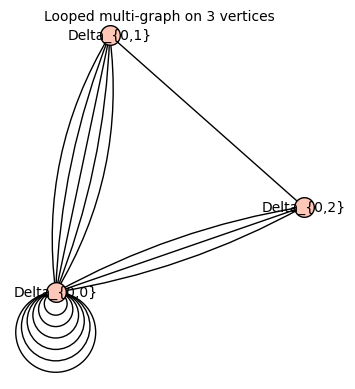

In [41]:
Sg.graph()

In [42]:
N=[[(Sg.n_cells(1)[i], 1)] for i in [0,1,2]]
N= N+[[(Sg.n_cells(1)[i], 1),(Sg.n_cells(1)[i], -1)] for i in range(3,6)]
N=N+[[(Sg.n_cells(1)[i], 2)] for i in [6,7]]

We compute a covering space projection $f: Z \to S_g$ such that $f_*(\pi_1(Z))=N$, where $Z$ is connected.

In [43]:
f = NormalCoveringSpaceLoops(Sg, N, check=True)

In [44]:
f.codomain().homology(), f.domain().homology()

({0: 0, 1: Z x Z x Z x Z, 2: Z}, {0: 0, 1: Z^6, 2: Z})

In [45]:
f.induced_homology_morphism().to_matrix()

[ 1| 0  0  0  0  0  0| 0]
[--+-----------------+--]
[ 0| 0  0  2  2  0  0| 0]
[ 0| 0 -1 -1 -1  1  0| 0]
[ 0| 0  1  2  1  0  0| 0]
[ 0| 1  0  1  0  0  1| 0]
[--+-----------------+--]
[ 0| 0  0  0  0  0  0| 2]

We have computed a double cover of the surface of genus $2$ by the surface of genus $3$.

### Construction of classifying spaces

The following function returns the $k$-skeleton of the classifying space of a given group. The algorithm is not meant to be used directly as SageMath can already compute classifying spaces. I just implemented this function for later use.

In [46]:
def k_skeleton_of_classifing_space(G, G_list,card, k):
    #G a finite group, G_list a list of its elements
    #card the cardinality of the group
    #k the dimension of the skeleton
    
    simp = {} 
    #simp will be dictionary with keys given by tuples 
    #each tuple will have length leq k entries in range(1,card)
    #the values of simp are the nondegenerate simplices of BG
    
    simp[0]=AbstractSimplex(0, name = '()' )
    sSet={simp[0]: None }
    
    # 1-cells 
    for s in range(1,card):
        simp[(s,)]=AbstractSimplex(1, name = str(s))
        sSet[simp[(s,)]]= (simp[0],simp[0])
        
    for n in range(2,k+1):
        for s in product(range(1, card), repeat=n):
            simp[s] = AbstractSimplex(n, name = str(s))
            faces = []
            faces.append(simp[s[1:]])
            for j in range(1,n):
                p = G_list.index(G_list[s[j-1]]*G_list[s[j]])
                if p == 0: #degenerate case
                    if n==2: 
                        faces.append(simp[0].apply_degeneracies(0))
                    else:
                        simplex = simp[s[0:(j-1)]+s[(j+1):len(s)]]
                        simplex = simplex.apply_degeneracies(j-1)
                        faces.append(simplex )
                else: 
                        faces.append(simp[s[0:(j-1)]+(p,)+s[(j+1):len(s)]] )
            faces.append(simp[s[0:(len(s)-1)]])
            sSet[simp[s]]=tuple(faces)
    BG = SimplicialSet(sSet, name = 'BG', base_point = simp[0])
    return BG

#### Very small example

We compute the $2$-skeleton of the classifying space of the symmetric group on $4$ letters.

In [47]:
H=SymmetricGroup(4)

In [48]:
BH_2 = k_skeleton_of_classifing_space(H, H.list(), H.cardinality(), 2)

In [49]:
BH_2.fundamental_group().is_isomorphic(SymmetricGroup(4))

#I  Forcing finiteness test


True

### Classifying map of normal covering space 

This implements part 2 of algorithm (1) from the enclosed bachelor thesis. The function is not meant to be directely called by the user, but we will use the funtion in later algorithms.

In [60]:
def construction_f_bar(X, gens, G): 
    #X the simplicial set, gens list of edges not in spanning tree,
    #G a presentation of pi_1(X)/N with generators given by gens 
    if not X.is_finite():
        raise ValueError("given simplicial set might not be finite")
        
    f_vec = X.f_vector()

    if not G.is_finite():
        raise ValueError("the quotient pi_1(X)/N is not finite")
        
    G_list = G.list()
    card = len(G_list)
    
    #construction of the dim X skeleton of BG: 
    simp = {} 
    #simp will be dictionary with keys given by tuples 
    #each tuple will have length leq k entries in range(1,card)
    #the values of simp are the nondegenerate simplices of BG
    
    simp[0]=AbstractSimplex(0, name = '()' )
    sSet={simp[0]: None }
    # 1-cells 
    for s in range(1,card):
        simp[(s,)]=AbstractSimplex(1, name = str(s))
        sSet[simp[(s,)]]= (simp[0],simp[0])
    for n in range(2,len(f_vec)):
        for s in product(range(1, card), repeat=n):
            simp[s] = AbstractSimplex(n, name = str(s))
            faces = []
            faces.append(simp[s[1:]])
            for j in range(1,n):
                p = G_list.index(G_list[s[j-1]]*G_list[s[j]])
                if p == 0: #degenerate case
                    if n==2: 
                        faces.append(simp[0].apply_degeneracies(0))
                    else:
                        simplex = simp[s[0:(j-1)]+s[(j+1):len(s)]]
                        simplex = simplex.apply_degeneracies(j-1)
                        faces.append(simplex )
                else: 
                        faces.append(simp[s[0:(j-1)]+(p,)+s[(j+1):len(s)]] )
            faces.append(simp[s[0:(len(s)-1)]])
            sSet[simp[s]]=tuple(faces)
    BG = SimplicialSet(sSet, name = 'BG', base_point = simp[0])
    
    # the morphism of simplicial sets X to BG that classifies X
    f = {v: simp[0] for v in X.n_cells(0)}
    for e in X.n_cells(1):
        if e in gens: 
            beta_e = G_list.index(G.gen(gens.index(e)))
            if beta_e == 0:
                f[e]=simp[0].apply_degeneracies(0)
            else:
                f[e]=simp[(beta_e,)]
        else: 
            f[e]=simp[0].apply_degeneracies(0)
    for n in range(2, len(f_vec)):
        for sigma in X.n_cells(n):
            d0 = X.face(sigma,0)
            dn=X.face(sigma,n)
            degens_n = dn.degeneracies()
            und_f_d0 = f[d0.nondegenerate()].nondegenerate()
            und_f_dn = f[dn.nondegenerate()].nondegenerate()
            degens_f_d0 = f[d0.nondegenerate()].degeneracies()
            degens_f_dn = f[dn.nondegenerate()].degeneracies()
            s0 = [s for s, simplex in simp.items() if simplex == und_f_d0][0] 
            #s0 is und_f_d0 as tuple
            sn = [s for s, simplex in simp.items() if simplex == und_f_dn][0]
            
            dim_d0 = d0.dimension()
            dim_d0_nd = d0.nondegenerate().dimension()
            
            cond = False 
            if und_f_d0.dimension()==0:
                cond = True
            if d0.degeneracies() != [] and d0.degeneracies()[0]>=dim_d0-1:
                cond = True 
            if degens_f_d0 != [] and degens_f_d0[0]>=dim_d0_nd-1:
                cond = True 
            
            if und_f_dn.dimension()==0 and cond:
                f[sigma]=simp[0].apply_degeneracies(*degens_f_dn)
                f[sigma]=f[sigma].apply_degeneracies(*degens_n)
                f[sigma]=f[sigma].apply_degeneracies(n-1)
            if und_f_dn.dimension()==0 and not cond:
                f[sigma]=simp[(s0[-1],)].apply_degeneracies(*degens_f_dn)
                f[sigma]=f[sigma].apply_degeneracies(*degens_n)
            if und_f_dn.dimension()!=0 and cond: 
                f[sigma]=simp[sn].apply_degeneracies(*degens_f_dn)
                f[sigma]=f[sigma].apply_degeneracies(*degens_n)
                f[sigma]=f[sigma].apply_degeneracies(n-1)
            if und_f_dn.dimension()!=0 and not cond:
                f[sigma]=simp[sn+(s0[-1],)].apply_degeneracies(*degens_f_dn)
                f[sigma]=f[sigma].apply_degeneracies(*degens_n)
                
    return SimplicialSetMorphism(f, X, BG), BG, simp, G, G_list, card

### Variant 1: User has to compute spanning tree

This function implements algorithm (1) from the enclosed bachelor thesis in the  unmodified version but omits the construction of the pullback. 

This version of the algorithm requires the user to give a finite simplicial set $X$ together with edges $e_1,\dots, e_m \in X_1^{\text{nd}}$ contained in a list $gens=[e_1,\dots, e_m]$ such that $X_1^{\text{nd}}\setminus \{e_1,\dots, e_m\}$ form the edges of a spanning tree in the $1$-skeleton of $X$. Whether this is satisfied, is checked by the following implementation. 

Further, the function has as input a list $N$ of elements in the free group $F(\{e_1,\dots, e_m\})$, such that the quotient of $F(\{e_1,\dots, e_m\})$ by $N$ union relations in $\pi_1(X)$ is a finite group $G$.

The function returns a morphism of simplicial sets $f: X \to BG$, where $BG$ is the $\dim(X)$-skeleton of the classifying space of $G$. Further,  $\pi_1(f)$ is surjective. Moreover, the pullback of the canonical map from the $\dim(X)$-skeleton of $EG$ to $BG$ along $f$ yields a covering projection $f: Z \to X$, such that $Z$ is a finite connected simplicial set and $f_*(\pi_1(Z))$ is the normal subgroup generated by the elements of $N$.

In [51]:
def classifying_map_tree(X, gens, N):
    return classifying_map_normal_covering_tree(X, gens, N)[0]

def classifying_map_normal_covering_tree(X, gens, N): 
    #X the simplicial set,
    #gens the list of edges not in spanning tree,
    #N relations in the free group F(gens)
    
    if not X.is_connected():
        raise ValueError("given simplicial set not connected")
        
    #next we check wether sk_1(X)-gens is a spanning tree in sk_1(X)
    treeSimplices = {}
    for e in [item for item in X.n_cells(1) if item not in gens]:
        treeSimplices[e]=(X.face(e,0), X.face(e,1))
    for v in X.n_cells(0):
        treeSimplices[v]=None
    tree = SimplicialSet(treeSimplices)
    if not tree.is_connected():
        raise ValueError("sk_1(X)-gens not spanning subgraph of sk_1(X)")
    if not tree.is_acyclic():
        raise ValueError("sk_1(X)-gens is not acyclic")
    if N == []: 
        FG = FreeGroup(len(gens), 'e')
    else: 
        if not len(N[0].parent().generators())==len(gens):
            raise ValueError("N not subset of free group on gens")
        FG = N[0].parent()
        for i in range(len(N)):
            if not N[i].parent()==FG:
                raise ValueError("N not subset of one group")
                
    #now we compute a presentation of pi_1(X)/N
    rels = []
    #adding the relations given by the 2-cells of X
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in gens:
                z[i]=FG.gen(gens.index(e))
            else: 
                z[i]=FG.one()
        rels.append(z[0]*z[1].inverse()*z[2])
        
    G = FG.quotient(rels+N)
    if not G.is_finite():
        raise ValueError("The quotient pi_1(X)/N is not finite")
    
    return construction_f_bar(X,gens,G)

#### Two small examples:

A triangulation of the torus as $\Delta$-complex with two $2$-simplices and a map classifying a finite sheeted covering space.

In [56]:
t = simplicial_sets.Torus() 
gens = t.n_cells(1)
FG=FreeGroup(len(gens), 'a')
N = [FG.gen(0)^7, FG.gen(1)^8]
classifying_map_tree(t, gens, N)

Simplicial set morphism:
  From: Torus
  To:   BG
  Defn: [(v_0, v_0), (s_0 v_0, sigma_1), (sigma_1, s_0 v_0), (sigma_1, sigma_1), (s_0 sigma_1, s_1 sigma_1), (s_1 sigma_1, s_0 sigma_1)] --> [(), 1, 3, 5, (1, 3), (3, 1)]

An example of simplicial sets which are not $\Delta$-complexes.

In [61]:
S2 = simplicial_sets.Sphere(2)
RP2 = simplicial_sets.RealProjectiveSpace(2)
S2xRP2 = S2.product(RP2)
G, gens = fundamental_group_w_gens(S2xRP2)
classifying_map_tree(S2xRP2, gens,[])

Simplicial set morphism:
  From: S^2 x RP^2
  To:   BG
  Defn: [(v_0, 1), (s_0 v_0, f), (s_1 s_0 v_0, f * f), (sigma_2, f * f), (sigma_2, s_0 f), (sigma_2, s_1 f), (sigma_2, s_1 s_0 1), (s_0 sigma_2, s_1 f * f), (s_0 sigma_2, s_2 f * f), (s_0 sigma_2, s_2 s_1 f), (s_1 sigma_2, s_0 f * f), (s_1 sigma_2, s_2 f * f), (s_1 sigma_2, s_2 s_0 f), (s_2 sigma_2, s_0 f * f), (s_2 sigma_2, s_1 f * f), (s_2 sigma_2, s_1 s_0 f), (s_1 s_0 sigma_2, s_3 s_2 f * f), (s_2 s_0 sigma_2, s_3 s_1 f * f), (s_2 s_1 sigma_2, s_3 s_0 f * f), (s_3 s_0 sigma_2, s_2 s_1 f * f), (s_3 s_1 sigma_2, s_2 s_0 f * f), (s_3 s_2 sigma_2, s_1 s_0 f * f)] --> [(), 1, (1, 1), (1, 1), s_0 1, s_1 1, s_1 s_0 (), s_1 (1, 1), s_2 (1, 1), s_2 s_1 1, s_0 (1, 1), s_2 (1, 1), s_2 s_0 1, s_0 (1, 1), s_1 (1, 1), s_1 s_0 1, s_3 s_2 (1, 1), s_3 s_1 (1, 1), s_3 s_0 (1, 1), s_2 s_1 (1, 1), s_2 s_0 (1, 1), s_1 s_0 (1, 1)]

#### Normal covering projection as pullback from classifying map

The following function implements all parts of algorithm (1) from the enclosed bachelor thesis in the unmodified version.

This version of the algorithm requires the user to give a finite simplicial set $X$ together with edges $e_1,\dots, e_m \in X_1^{\text{nd}}$ contained in a list $gens=[e_1,\dots, e_m]$ such that $X_1^{\text{nd}}\setminus \{e_1,\dots, e_m\}$ form the edges of a spanning tree in the $1$-skeleton of $X$. Whether this is satisfied, is checked by the following implementation. 

Further, the function has as input a list $N$ of elements in the free group $F(\{e_1,\dots, e_m\})$, such that the quotient of $F(\{e_1,\dots, e_m\})$ by $N$ union relations in $\pi_1(X)$ is a finite group $G$.

The function returns the pullback $Z$ of the diagram $X\xrightarrow{f}BG\xleftarrow{} EG$, where $BG$ is the $\dim(X)$-skeleton of the classifying space of $G$, $EG$ is a universal cover of $BG$ and $f$ is a morphism of simplicial sets constructed in such a way that the following hold: 
1) The canonical map $p:Z\to X$ is a covering projection. 
2) $Z$ is connected 
3) $p_*(\pi_1(Z))$ is the subgroup of $\pi_1(X)$ generated by the elements of $N$
3) $\pi_1(f)$ is surjective.

In [62]:
def NormalCoveringSpaceFromClassifyingSpaceTree(X, gens, N): 
    
    #X the simplicial set,
    #gens the list of edges not in spanning tree,
    #N relations in the free group F(gens)
    f, BG,simpBG, G, G_list,card=classifying_map_normal_covering_tree(X,gens,N)
    
    # construction of the dim X skeleton of EG and the covering map q: EG to BG
    simp = {(s,): AbstractSimplex(0, name='('+str(s)+')') for s in range(card)}
    
    #simp is a dictionary with keys given by tuples 
    #each tuples has entries in range(card) and length leq dim X 
    #the values of the dictionary simp are the simplices of EG
    
    q = {simp[(s,)]: simpBG[0] for s in range(0,card)}
    sSet={simp[(s,)]: None for s in range(0, card)}
    
    for n in range(1,X.dimension()+1):
        for s in product(range(0, card), repeat=(n+1)):
            if not any([s[i]==s[i+1] for i in range(0, n)]):
                # s gives non-degenerate of EG
                simp[s] = AbstractSimplex(n, name = str(s))
                faces = []
                for i in range(0, n+1):
                    if i>0 and i<n and s[i-1]==s[i+1]:
                        simplex = simp[s[0:i]+s[(i+2):len(s)]]
                        simplex = simplex.apply_degeneracies(i-1)
                        faces.append(simplex)
                    else: 
                        faces.append(simp[s[0:i]+s[(i+1):len(s)]])
                sSet[simp[s]]=tuple(faces)
                g_s = [G_list[s[i]].inverse()*G_list[s[i+1]] for i in range(n)]
                q_s = [G_list.index(g) for g in g_s]
                q[simp[s]]=simpBG[tuple(q_s)]
    EG = SimplicialSet(sSet, name='EG', base_point=simp[(0,)])
    q_mor = SimplicialSetMorphism(q, EG, BG)
    return BG.pullback(f, q_mor)

#### Example: A triangulation of the torus as $\Delta$-complex with two $2$-simplices

In [63]:
t = simplicial_sets.Torus()

In [64]:
gens =  t.n_cells(1)
FG=FreeGroup(len(gens))
N = [FG.gen(0)^3, FG.gen(1)^3]

In [65]:
Z= NormalCoveringSpaceFromClassifyingSpaceTree(t, gens, N)

We extract the covering projection from the pullback. Then, we check, whether $Z$ has the reduced homology of a torus.

In [66]:
p=Z.structure_map(0); Z.homology()

{0: 0, 1: Z x Z, 2: Z}

The covering projection $p$ induces the following map on homology:

In [591]:
p_star = p.induced_homology_morphism(); p_star.to_matrix()

[ 1| 0  0| 0]
[--+-----+--]
[ 0| 3 -3| 0]
[ 0| 0  3| 0]
[--+-----+--]
[ 0| 0  0| 9]

We see that $p$ has degree $9$ and $Z$ is a $9$-sheeted covering space of the torus.

Let us do an example with different $N$:

In [67]:
N=[FG.gen(1)^4, FG.gen(2)^3]

In [68]:
Z= NormalCoveringSpaceFromClassifyingSpaceTree(t, gens, N) 

We extract the covering projection from the pullback. Then, we check, whether $Z$ has the reduced homology of a torus.

In [69]:
p=Z.structure_map(0); Z.homology()

{0: 0, 1: Z x Z, 2: Z}

The covering projection $p$ induces the following map on homology:

In [70]:
p_star = p.induced_homology_morphism(); p_star.to_matrix()

[ 1| 0  0| 0]
[--+-----+--]
[ 0| 4 -8| 0]
[ 0|-3  9| 0]
[--+-----+--]
[ 0| 0  0|12]

By definition of $N$ the subgroup of $\pi_1(\mathbb{T})$ generated by the elements of $N$ is given by $4\mathbb{Z}\oplus 3\mathbb{Z}$. So, the quotient of $\pi_1(\mathbb{T})$ by this subgroup is given by 
$\mathbb{Z}/(4)\oplus \mathbb{Z}/(3)$, which is isomorphic to $\mathbb{Z}/12$, since $3$ and $4$ are coprime. 

Indeed:

In [71]:
BG=Z.defining_map(0).codomain(); BG.homology() 

{0: 0, 1: C12, 2: Z^110}

Bringing the matrix of $H_1(p)$ computed above in Smith normal form yields:

In [72]:
matrix([[4, -8],[-3,9]]).smith_form() 

(
[ 1  0]  [1 1]  [ 1 -1]
[ 0 12], [3 4], [ 0  1]
)

So, indeed $H_1(\mathbb{T})/p_*(H_1(Z))\cong \mathbb{Z}/12$. 

### Variant 2: User gives the normal subgroup by loops

This implements algorithm (1) from the enclosed bachelor thesis in the  unmodified version but omits the construction of the pullback. 

So, the function has input $X$, a finite connected simplicial set, and $N$, where $N$ is a list of lists, $N=[n_0, \dots, n_s]$.

Each $n_i$ is a list of tuples $(\sigma_{i_1}, k_{i_1}),\dots, (\sigma_{i_{r_i}}, k_{r_i})$ for each $\sigma_{i_j}$ a nondegenerate $1$-simplex of $X$ and $k_{i_j}\in \mathbb{Z}$ such that $\sigma_{i_1}^{k_{i_1}}*\dots*\sigma_{i_{r_i}}^{k_{r_i}}$ is forming a loop in the 1-skeleton of $X$. 

The condition that $n_i$ defines a loop says that  

$$\text{for all $j=1,\dots, r_i$ } \quad  \begin{cases}
    d_0(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}, k_{i_{j+1  \text{ mod } r_i}}>0\\
    d_0(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}>0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}<0\\
    d_1(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}<0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}>0\\
    d_1(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}, k_{i_{j+1 \text{ mod } r_i}}<0.
\end{cases}
$$ 
and $d_0(\sigma_{i_j})=d_1(\sigma_{i_j})$ if $|k_{i_j}|>1$.

The function returns a morphism of simplicial sets $f: X \to BG$, where $BG$ is the $\dim(X)$-skeleton of the classifying space of $G$. Further,  $\pi_1(f)$ is surjective. Moreover, the pullback of the canonical map from the $\dim(X)$-skeleton of $EG$ to $BG$ along $f$ yields a covering projection $f: Z \to X$, such that $Z$ is a finite connected simplicial set and $f_*(\pi_1(Z))$ is the normal subgroup generated by the elements of $N$.

If the function is called with the boolean check set to True, then it is check whether $N$ is of the above form.

In [73]:
def classifying_map_loops(X, N, check=True):
    return classifying_map_normal_covering_loops(X, N, check)[0]

def classifying_map_normal_covering_loops(X, N, check=True):
    
    #X a finite connected simplicial set, 
    #N loops in the 1-skeleton of X given in the above form
    
    if not X.is_connected():
        raise ValueError("given simplicial set not connected")
        
    #We  check whether N is of the required form: 
    if check:
        for n in N:
            for j in range(len(n)):
                s,k = n[j]
                s1, k1 = n[(j+1)%len(n)]
                if abs(k)>1 and X.face(s, 0)!=X.face(s, 1):
                    raise ValueError("N doens't consist of loops")
                if k>0 and k1>0 and X.face(s, 0) != X.face(s1, 1):
                    raise ValueError("N doens't consist of loops")
                if k>0 and k1<0 and X.face(s, 0) != X.face(s1, 0):
                    raise ValueError("N doens't consist of loops")
                if k<0 and k1>0 and X.face(s, 1)!= X.face(s1, 1):
                    raise ValueError("N doens't consist of loops")
                if k<0 and k1<0 and X.face(s, 1)!= X.face(s1, 0):
                    raise ValueError("N doens't consist of loops")
                      
    #we compute a presentation of the fundamental group G of X
    graph = X.graph() #graph with edges the non-degenerate 1-cells
    edges = [e[2] for e in graph.edges()]
    spanning_tree = [e[2] for e in graph.min_spanning_tree()]
    gens = [e for e in edges if e not in spanning_tree]
    FG = FreeGroup(len(gens), 'e')
    rels = []
    #adding the relations given by the 2-cells
    for f in X.n_cells(2):
        z = dict()
        for i in range(3):
            e = X.face(f,i)
            if e.is_degenerate():
                z[i]=FG.one()
            elif e in spanning_tree:
                z[i]=FG.one()
            else: 
                z[i]=FG.gen(gens.index(e))
        rels.append(z[0]*z[1].inverse()*z[2])
    
    # presentation of normal subgroup of pi_1(X) generated by N
    N_pr = []
    for n in N:
        n_pr=FG.one()
        for e,k in n:
            if e in gens:
                n_pr=n_pr*FG.gen(gens.index(e))^k
        N_pr.append(n_pr)
    
    G = FG.quotient(rels+N_pr)
    
    return construction_f_bar(X,gens,G)

#### A example: Triangulation of the torus as $\Delta$-complex with two $2$-simplices.

In [74]:
torus = simplicial_sets.Torus()

In [75]:
N=[[(torus.n_cells(1)[1], 2)], [(torus.n_cells(1)[0], -3)]]

In [76]:
f = classifying_map_loops(torus, N, check=True); f

Simplicial set morphism:
  From: Torus
  To:   BG
  Defn: [(v_0, v_0), (s_0 v_0, sigma_1), (sigma_1, s_0 v_0), (sigma_1, sigma_1), (s_0 sigma_1, s_1 sigma_1), (s_1 sigma_1, s_0 sigma_1)] --> [(), 1, 3, 4, (1, 3), (3, 1)]

#### Normal covering projection as pullback

The following function implements all parts of algorithm (1) from the enclosed bachelor thesis in the version modified as in algorithm (4). 

So, the function has input $X$, a finite connected simplicial set, and $N$, where $N$ is a list of lists, $N=[n_0, \dots, n_s]$.

Each $n_i$ is a list of tuples $(\sigma_{i_1}, k_{i_1}),\dots, (\sigma_{i_{r_i}}, k_{r_i})$ for each $\sigma_{i_j}$ a nondegenerate $1$-simplex of $X$ and $k_{i_j}\in \mathbb{Z}$ such that $\sigma_{i_1}^{k_{i_1}}*\dots*\sigma_{i_{r_i}}^{k_{r_i}}$ is forming a loop in the 1-skeleton of $X$. 

The condition that $n_i$ defines a loop says that  

$$\text{for all $j=1,\dots, r_i$ } \quad  \begin{cases}
    d_0(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}, k_{i_{j+1  \text{ mod } r_i}}>0\\
    d_0(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}}) & \text{if } k_{i_{j}}>0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}<0\\
    d_1(\sigma_{i_j})=d_1(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}<0 \text{ and } k_{i_{j+1 \text{ mod } r_i}}>0\\
    d_1(\sigma_{i_j})=d_0(\sigma_{i_{j+1\text{ mod } r_i}})& \text{if } k_{i_{j}}, k_{i_{j+1 \text{ mod } r_i}}<0.
\end{cases}
$$ 
and $d_0(\sigma_{i_j})=d_1(\sigma_{i_j})$ if $|k_{i_j}|>1$.

If the function is called with the boolean check set to True, then it is check whether $N$ is of the above form.

The function returns the pullback $Z$ of the diagram $X\xrightarrow{f}BG\xleftarrow{} EG$, where $BG$ is the $\dim(X)$-skeleton of the classifying space of $G$, $EG$ is a universal cover of $BG$ and $f$ is a morphism of simplicial sets constructed in such a way that the following hold: 
1) The canonical map $p:Z\to X$ is a covering projection. 
2) $Z$ is connected 
3) $p_*(\pi_1(Z))$ is the subgroup of $\pi_1(X)$ generated by the elements of $N$
3) $\pi_1(f)$ is surjective.

In [77]:
def NormalCoveringSpaceFromClassifyingSpaceLoops(X, N, check=True): 
    #X a finite connected simplicial set
    #N loops in pi_1(X) generating a normal subgroup of fin. index
    f,BG,simpBG, G,G_list,card=classifying_map_normal_covering_loops(X,N,check)

    # construction of the dim X skeleton of EG and the covering map q: EG to BG
    
    simp = {(s,): AbstractSimplex(0, name='('+str(s)+')') for s in range(card)}
    #simp is a dictionary with keys given by tuples 
    #each tuples has entries in range(card) and length leq dim X 
    #the values of the dictionary simp are the simplices of EG
    
    q = {simp[(s,)]: simpBG[0] for s in range(0,card)}
    sSet={simp[(s,)]: None for s in range(0, card)}
    
    for n in range(1,X.dimension()+1):
        for s in product(range(0, card), repeat=(n+1)):
            if not any([s[i]==s[i+1] for i in range(0, n)]):
                # s gives non-degenerate of EG
                simp[s] = AbstractSimplex(n, name = str(s))
                faces = []
                for i in range(0, n+1):
                    if i>0 and i<n and s[i-1]==s[i+1]:
                        simplex = simp[s[0:i]+s[(i+2):len(s)]]
                        simplex = simplex.apply_degeneracies(i-1)
                        faces.append(simplex)
                    else: 
                        faces.append(simp[s[0:i]+s[(i+1):len(s)]])
                sSet[simp[s]]=tuple(faces)
                g_s = [G_list[s[i]].inverse()*G_list[s[i+1]] for i in range(n)]
                q_s = [G_list.index(g) for g in g_s]
                q[simp[s]]=simpBG[tuple(q_s)]
    EG = SimplicialSet(sSet, name='EG', base_point=simp[(0,)])
    q_mor = SimplicialSetMorphism(q, EG, BG)
    return BG.pullback(f, q_mor)

##### Example: A triangulation of the torus as a $\Delta$-complex with two $2$-simplices:

We compute a double cover of the torus by pullying back the universal covering projection $S^2\to \mathbb{R}P^2$.

In [78]:
torus=simplicial_sets.Torus()

In [79]:
N=[[(torus.n_cells(1)[1], 1)], [(torus.n_cells(1)[0], 2)]]

In [80]:
Z = NormalCoveringSpaceFromClassifyingSpaceLoops(torus, N)

In [81]:
Z.homology()

{0: 0, 1: Z x Z, 2: Z}

In [82]:
Z.structure_map(0).induced_homology_morphism().to_matrix()

[ 1| 0  0| 0]
[--+-----+--]
[ 0| 1 -1| 0]
[ 0| 0  2| 0]
[--+-----+--]
[ 0| 0  0| 2]

#  Join of simplicial sets and construction of lens spaces

### Join of two simplicial sets

For later use we compute the join of simplicial sets. 

In [83]:
def join(s,t, simplices_non_distinct = True):
    if not (s.is_finite() and t.is_finite()):
        raise ValueError("the given simplicial sets might not be finite")
        
    # we force s,t to have no simplices in common
    if simplices_non_distinct:
        t = copy(t) 
    #the naming of the simplices in this copy is not always as one expects
    simplices = {}
    data = {}
    for d in range(len(s.f_vector())+len(t.f_vector())+1): #dim of the join
        for i in range(-1, d+1):
            if i == -1: 
                for simp in s.n_cells(d):
                    simplices[simp]=s.faces(simp)
            elif d-i-1 >= 0:
                for simp1 in s.n_cells(i):
                    for simp2 in t.n_cells(d-i-1):
                        name = str(simp1) + ' join ' +str(simp2)
                        simp = AbstractSimplex(d, name=name)
                        data[(simp1, simp2)] = simp   
                        simp_faces = []
                        for k in range(d+1):
                            if  k <= i: 
                                if i==0:
                                    simp_faces.append(simp2)
                                elif s.face(simp1,k).is_nondegenerate():
                                    simp_faces.append(data[(s.face(simp1,k),simp2)])
                                else:
                                    f = s.face(simp1,k)
                                    underlying = f
                                    for l in f.degeneracies():
                                        underlying = s.face(underlying, l)
                                    new = AbstractSimplex(underlying.dimension()+d-i, degeneracies=f.degeneracies(), underlying = data[(underlying, simp2)])
                                    #new.dim() = underlying.dimension()+d-i
                                    simp_faces.append(new)                                        
                            else:
                                if d-i-1==0:
                                    simp_faces.append(simp1)
                                elif t.face(simp2,k-i-1).is_nondegenerate():
                                    simp_faces.append(data[(simp1,t.face(simp2,k-i-1))])
                                else:
                                    f= t.face(simp2,k-i-1)
                                    underlying = f
                                    for l in f.degeneracies():
                                        underlying = t.face(underlying, l)
                                    degeneracies = tuple([m + 1 + i for m in f.degeneracies()])
                                    new = AbstractSimplex(i+underlying.dimension()+1, degeneracies=degeneracies, underlying = data[(simp1, underlying)])
                                    simp_faces.append(new)
                        simplices[simp]=tuple(simp_faces)
            elif d-i-1 == -1:
                 for simp in t.n_cells(d):
                    simplices[simp]=t.faces(simp)
    return SimplicialSet(simplices),  data

#### A very small example: 
We define $S^5$ to be the simplicial set with two nondegenerate simplices, where one of these two is a $5$-simplex.

In [84]:
s5 = simplicial_sets.Sphere(5)

The join $S^5\star S^5$ should yield $S^{11}$, which has the following reduced homology:

In [85]:
s11 = join(s5,s5)[0]; s11.homology()

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: Z}

### Join of morphisms of simplicial sets

For later use we also implement the join of morphisms of simplicial sets.

The following code needs the simplices of the codomains and the simplices of the domains to be distinct, respectively. this can be achieved by first using copy().

In [86]:
def joinMorph(f, g ):
    d1 = f.domain()
    d2 = g.domain()
    c1 = f.codomain()
    c2 = g.codomain()
    if not (d1.is_finite() and d2.is_finite() and c1.is_finite() and c2.is_finite()):
        raise ValueError("the given simplicial sets might not be finite")
    if (d1==c1 and d2 == c2): 
        return joinEndo(f,g)
    C,  C_data = join(c1, c2, False)
    F = {}
    simplices = {}
    data = {}
    for d in range(len(d1.f_vector())+len(d2.f_vector())+1): #dim of the join
        for i in range(-1, d+1):
            if i == -1: 
                for simp in d1.n_cells(d):
                    simplices[simp]=d1.faces(simp)
                    F[simp]=f(simp)
            elif d-i-1 >= 0:
                for simp1 in d1.n_cells(i):
                    for simp2 in d2.n_cells(d-i-1):
                        name = str(simp1) + ' join ' +str(simp2)
                        simp = AbstractSimplex(d, name=name)
                        data[(simp1, simp2)] = simp 
                        F[simp]= C_data[(f(simp1), g(simp2))]
                        simp_faces = []
                        for k in range(d+1):
                            if  k <= i: 
                                if i==0:
                                    simp_faces.append(simp2)
                                elif d1.face(simp1,k).is_nondegenerate():
                                    simp_faces.append(data[(d1.face(simp1,k),simp2)])
                                else:
                                    f = d1.face(simp1,k)
                                    underlying = f
                                    for l in f.degeneracies():
                                        underlying = d1.face(underlying, l)
                                    new = AbstractSimplex(underlying.dimension()+d-i, degeneracies=f.degeneracies(), underlying = data[(underlying, simp2)])
                                    #new.dim=underlying.dimension()+d-i
                                    simp_faces.append(new)                                        
                            else:
                                if d-i-1==0:
                                    simp_faces.append(simp1)
                                elif d2.face(simp2,k-i-1).is_nondegenerate():
                                    simp_faces.append(data[(simp1,d2.face(simp2,k-i-1))])
                                else:
                                    f= d2.face(simp2,k-i-1)
                                    underlying = f
                                    for l in f.degeneracies():
                                        underlying = d2.face(underlying, l)
                                    degeneracies = tuple([m + 1 + i for m in f.degeneracies()])
                                    new = AbstractSimplex(i+underlying.dimension()+1, degeneracies=degeneracies, underlying = data[(simp1, underlying)])
                                    simp_faces.append(new)

                        simplices[simp]=tuple(simp_faces)
            elif d-i-1 == -1:
                 for simp in d2.n_cells(d):
                    simplices[simp]=d2.faces(simp)
                    F[simp]=g(simp)
    return SimplicialSetMorphism(F, SimplicialSet(simplices), C)

For better performance, we will also implement the join in the case that $d_1=c_1$ and $d_2 =c_2$, separately.

In [87]:
def joinEndo(f, g):
    d1 = f.domain()
    d2 = g.domain()
    c1 = f.codomain()
    c2 = g.codomain()
    if not (d1.is_finite() and d2.is_finite() and c1.is_finite() and c2.is_finite()):
        raise ValueError("the given simplicial sets might not be finite")
    if not (d1==c1 and d2 == c2): 
        raise ValueError("the domains don't equale the codomains")
        
    ## first building the simplicial set
    simplices = {}
    data = {}
    F = {} #the morphism
    for d in range(len(d1.f_vector())+len(d2.f_vector())+1): #the dimension of the join
        for i in range(-1, d+1):
            if i == -1: 
                for simp in d1.n_cells(d):
                    simplices[simp]=d1.faces(simp)
                    F[simp]=f(simp)
            elif d-i-1 >= 0:
                for simp1 in d1.n_cells(i):
                    for simp2 in d2.n_cells(d-i-1):
                        name = str(simp1) + ' join ' +str(simp2)
                        simp = AbstractSimplex(d, name=name)
                        data[(simp1, simp2)] = simp 
                        simp_faces = []
                        for k in range(d+1):
                            if  k <= i: 
                                if i==0:
                                    simp_faces.append(simp2)
                                elif d1.face(simp1,k).is_nondegenerate():
                                    simp_faces.append(data[(d1.face(simp1,k),simp2)])
                                else:
                                    f = d1.face(simp1,k)
                                    underlying = f
                                    for l in f.degeneracies():
                                        underlying = d1.face(underlying, l)
                                    new = AbstractSimplex(underlying.dimension()+d-i, degeneracies=f.degeneracies(), underlying = data[(underlying, simp2)])
                                    simp_faces.append(new)                                        
                            else:
                                if d-i-1==0:
                                    simp_faces.append(simp1)
                                elif d2.face(simp2,k-i-1).is_nondegenerate():
                                    simp_faces.append(data[(simp1,d2.face(simp2,k-i-1))])
                                else:
                                    f= d2.face(simp2,k-i-1)
                                    underlying = f
                                    for l in f.degeneracies():
                                        underlying = d2.face(underlying, l)
                                    degeneracies = tuple([m + 1 + i for m in f.degeneracies()])
                                    new = AbstractSimplex(i+underlying.dimension()+1, degeneracies=degeneracies, underlying = data[(simp1, underlying)])
                                    simp_faces.append(new)

                        simplices[simp]=tuple(simp_faces)
            elif d-i-1 == -1:
                 for simp in d2.n_cells(d):
                    simplices[simp]=d2.faces(simp)
                    F[simp]=g(simp)
    #specifiying the morphism
        for i in range(0, d):
            for simp1 in d1.n_cells(i):
                for simp2 in d2.n_cells(d-i-1):
                    F[data[(simp1, simp2)]]=data[(f(simp1), g(simp2))]
    D = SimplicialSet(simplices)
    return SimplicialSetMorphism(F, D, D)

### Construction of Lens Spaces

$Z_p$ acts on $S^1$ by multiplication with $\zeta^{q_i}$ for $\zeta$ a $p$-th root of unity and $q_i\in \mathbb{Z}$. Choosing $q_1, \dots, q_n$ and defining $\rho_i: S^1\to S^1, \rho_i(z)= \zeta^{q_i}\cdot z$, we obtain an action of $\mathbb{Z}_p$ on $S^{2n-1}$ generated by $F = \rho_1 \star \dots \star \rho_n: S^1 \star \dots \star S^1 \to S^1 \star \dots \star S^1$, noting that the $n$-fold join of $S^1$ is homeomorphic to $S^{2n-1}$. 

The following function takes as input a positive integer $p \in \mathbb{Z}_{>0}$ and a list of integers $qs=[q_1, \dots, q_n]$. It returns the map $F: S^{2n-1}\to S^{2n-1}$ we described above. Further, the function returns the quotient map $q: S^{2n-1}\to S^{2n-1}/\mathbb{Z}_p$ to the orbits space of the action of $\mathbb{Z}_p=\mathbb{Z}/(p)$ on $S^{2n-1}$ generated by $F$.  The codomain of $q$ is called a lens space and denoted $L(p; q_1,\dots, q_n)$ if and only if  gcd$(q_i, p)=q$ for all $i=1,\dots, n$.

If $L(p;q_1,\dots, q_n)$ is a lens space, then $q$ is a universal covering projection.


The function takes as input a boolean "check". If check is true, the function checks whether the given integers $q_1,\dots, q_n$ are all coprime to $p$ and whether $p$ is positive. 

In [88]:
def covLens(p,qs, check=True):
    if check:
        if not p>0:
            raise ValueError("p is not a positive integer")
        for q in qs:
            if not numpy.gcd(p,q) == 1:
                raise ValueError("the q's are not all coprime to p")
    v={}; e={}; S1s = {}; f={}
    for d in range(len(qs)):
        v[d] = [AbstractSimplex(0, name = 'v' +str(i)+'^('+str(d)+')') for i in range(p)]
        e[d] = [AbstractSimplex(1, name = 'e' +str(i)+'^('+str(d)+')') for i in range(p)]
        S1s[d] = SimplicialSet({e[d][i]: (v[d][i], v[d][(i+1)%p]) for i in range(p)}, name = 'S^1_'+str(d))
        f[d] = SimplicialSetMorphism({e[d][i]: e[d][(i+qs[d])%p] for i in range(p)}, S1s[d], S1s[d])
    F = f[0]
    for i in range(len(qs)-1):
        F=joinEndo(F, f[i+1])
    q = F.coequalizer(SimplicialSetMorphism(domain=F.domain(), codomain = F.codomain(), identity=True))
    return F,q

#### Some lens spaces

$F511: S^3\to S^3$ will be an automorphism of $S^3$ generating an action of $\mathbb{Z}/5$. $q511$ will be the coequalizer of the identity $S^3\to S^3$ and $F511$. $F511$ was constructed in such a way, that $q511$ is the lens space $L(5;1,1)$. The structure map $S^3\to q511$ of the coequalizer, will be the universal covering projection $S^3\to L(5;1,1)$.

In [89]:
F511, q511 = covLens(5,[1,1])

In [96]:
F511.domain().homology() #reduced homology of S^3

{0: 0, 1: 0, 2: 0, 3: Z}

In [97]:
q511.homology() #reduced homoloty of L(5;1,1)

{0: 0, 1: C5, 2: 0, 3: Z}

Sometimes we are only interested in the lens space and not in the group action. So, we define a function that just returns the lens space. 

The following function takes as input a positive integer $p \in \mathbb{Z}_{>0}$, a list of integers $qs=[q_1, \dots, q_n]$ and
a boolean "check". If check is true, the function checks whether the given integers $q_1,\dots, q_n$ are all coprime to $p$ and whether $p$ is positive. 

The function returns a simplicial set, whose geometric realization is homeomorphic to $L(p; q_1,\dots, q_n)$.

In [98]:
def lens(p,qs, check=True):
    return SimplicialSet(covLens(p,qs, check)[1])

Let us compute the reduced homology of $L(4;-1,3)$. Note that C4 denotes the cyclic group with four elements in SageMath.

In [99]:
lens(4, [-1,3]).homology() 

{0: 0, 1: C4, 2: 0, 3: Z}

Let us construct a $5$-dimensional lens space.

In [100]:
L4_135 = lens(4,[1,-1,5]) 

We compute the reduced homology of $L(4; 1,-1,5)$. 

In [101]:
L4_135.homology()

{0: 0, 1: C4, 2: 0, 3: C4, 4: 0, 5: Z}

Let us compute the normalized chain complex of $S^3$ by giving its matrices with respect to a $\mathbb{Z}[C5]$-basis' of its chain groups. The basis elements are given by lifts of nondegenerate simplices of $L(5;1,3)$ along the covering projection $S^3\to L(5;1,3)$. Here $C5$ denotes the cyclic group with five elements.

In [102]:
C_L513=complexOfUniversalCover(lens(5, [1,3]), True)

In [103]:
C_L513[1].base_ring()

Algebra of Finitely presented group < e0 | e0^5 > over Integer Ring

We print "C_L513" in LaTeX:

$$\left\{1 : \; \left(\begin{array}{rrrrrrr}
-1 + e_{0} & 0 & -1 & -1 & -1 & -1 & -1 \\
0 & -1 + e_{0}^{2} & 1 & e_{0}^{-2} & e_{0} & e_{0}^{-1} & e_{0}^{2}
\end{array}\right),\quad  2 :\; \left(\begin{array}{rrrrrrrrrr}
1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & e_{0}^{-2} & e_{0} & e_{0}^{-1} & e_{0}^{2} & 1 \\
e_{0} & 0 & 0 & -1 & 0 & -1 & 0 & 0 & 0 & 1 \\
0 & e_{0} & 0 & 0 & -1 & 1 & -1 & 0 & 0 & 0 \\
-1 & 0 & e_{0} & 0 & 0 & 0 & 1 & -1 & 0 & 0 \\
0 & -1 & 0 & e_{0} & 0 & 0 & 0 & 1 & -1 & 0 \\
0 & 0 & -1 & 0 & e_{0} & 0 & 0 & 0 & 1 & -1
\end{array}\right), \quad 3 :\; \left(\begin{array}{rrrrr}
1 & 0 & 0 & 0 & -1 \\
-1 & 1 & 0 & 0 & 0 \\
0 & -1 & 1 & 0 & 0 \\
0 & 0 & -1 & 1 & 0 \\
0 & 0 & 0 & -1 & 1 \\
e_{0} & 0 & 0 & -1 & 0 \\
0 & e_{0} & 0 & 0 & -1 \\
-1 & 0 & e_{0} & 0 & 0 \\
0 & -1 & 0 & e_{0} & 0 \\
0 & 0 & -1 & 0 & e_{0}
\end{array}\right)\right\}$$

Let us compute the normalized chain complex of $S^5$ by giving its matrices with respect to a $\mathbb{Z}[C4]$-basis' of its chain groups. The basis elements are given by lifts of nondegenerate simplices of $L(4;1,-1,5)$ along the covering projection $S^5\to L(4;1,-1,5)$. Here $C4$ denotes the cyclic group with five elements.

In [105]:
C_L4_135=complexOfUniversalCover(L4_135, True)

In [106]:
C_L4_135[1].base_ring()

Algebra of Finitely presented group < e0 | e0^4 > over Integer Ring

# Reidemeister Torsion

### Construction of the twist complex

The following function implements algorithm (8) of the enclosed bachelor thesis but only returns the twist complex not the Reidemeister torsion. 

The function takes as input a connected, finite simplicial set $X$, as well as, list of edges $gens =[e_1,\dots, e_m]$ in $X$ such that $\text{sk}_1(X)\setminus\{e_1,\dots, e_m\}$ is a spanning tree in the $1$-skeleton of $X$. 

Secondly, the function takes a list of matrices $\phi=\{M_1,\dots, M_m\}$, which are all complex square matrices of the same size such that sending $e_i \mapsto M_i$ induces a group homomorphism $\pi_1(X)\to \text{GL}(n, \mathbb{C})$. Here we use a presentation of $\pi_1(X)$ with generators $e_1,\dots, e_m$ and relations given by the $2$-simplices of $X$. 

The function takes as input a boolean "check", which is by default set True. If "check" is set True, then the algorithm checks, whether those conditions above are satisfied.

The function returns the chain complex $C(X, \phi)$ of finite dimensional $\mathbb{C}$-vector spaces defined in definition 3.15 of the enclosed bachelor thesis by giving the matrices of the boundary operators with respect to the distinguished basis.

In [117]:
def twistComplex(X, gens, phi, check=True):
    
    #X: finite connected simplicial set, 
    #gens: edges not contained in fixed spanning tree of sk_1(X) 
    #phi: lists of matrices assigned to the gens,
    #such that e[i] -> phi[i] gives representation of p_1(X)
    #if Check, then we check if phi really is a representation
    
    if not X.is_finite():
        raise ValueError("given simplicial set might not be finite")
    f_vec = X.f_vector()
    if len(f_vec)<2:
        return X.chain_complex() 
    if not X.is_connected():
        raise ValueError("given simplicial set is not connected")
    if len(gens)!=len(phi):
        raise ValueError("len(gens)!=len(phi)")
        
    #check if all matrices have the same size:
    if len(phi)>0:
        n = phi[0].dimensions()[0]
    else:
        n = 1
    for i in range(len(gens)):
        if not (n==phi[i].dimensions()[0] and n==phi[i].dimensions()[1]):
            raise ValueError('given matrizes are not of the same size')
            
    #for later extensive  use 
    I = matrix.identity(n,CDF)
    
    #next we check whether sk_1(X)-gens is a spanning tree in sk_1(X)
    if check: 
        treeSimplices = {}
        for e in [item for item in X.n_cells(1) if item not in gens]:
            treeSimplices[e]=(X.face(e,0), X.face(e,1))
        for v in X.n_cells(0):
            treeSimplices[v]=None
        tree = SimplicialSet(treeSimplices)
        if not tree.is_connected():
            raise ValueError("sk_1(X)-gens not spanning subgraph of sk_1(X)")
        if not tree.is_acyclic():
            raise ValueError("sk_1(X)-gens is not acyclic")
            
        #next we check if phi really is a homomorphism,
        #so we check wheter the relations in pi_1(X) are satisfied
        for f in X.n_cells(2):
            z = dict()
            for i in range(3):
                e = X.face(f,i)
                if e.is_degenerate():
                    z[i]=matrix.identity(n)
                elif e in gens:
                    z[i]=phi[gens.index(e)]
                else: 
                    z[i]=matrix.identity(n)
            if not numpy.allclose(z[0]*z[1].inverse()*z[2], I):
                raise ValueError("phi is not a homomorphism")
        
    deckTrnsf = {i: [] for i in range(1, len(f_vec))} 
    twistComplx = {}
    for i in range(1, len(f_vec)):
        twistComplx[i] = matrix(CDF, f_vec[i-1]*n, f_vec[i]*n)
    #we start with 0 matrices and fill their entries later
    

                                        
    for j in range(f_vec[1]):
        e = X.n_cells(1)[j]
        ind_d0 = X.n_cells(0).index(X.face(e,0))
        ind_d1 = X.n_cells(0).index(X.face(e,1))
        twistComplx[1][n*ind_d1:n*(ind_d1+1),n*j:n*(j+1)] -= I
        if e in gens:
            i = gens.index(e)
            twistComplx[1][n*ind_d0:n*(ind_d0+1), n*j:n*(j+1)] +=phi[i]
            deckTrnsf[1].append(phi[i])
        else:
            twistComplx[1][n*ind_d0:n*(ind_d0+1),n*j: n*(j+1)] += I
            deckTrnsf[1].append(I)
    
    for k in range(2, len(f_vec)):
        for j in range(f_vec[k]):
            f = X.n_cells(k)[j]
            for m in range(1, k+1):
                if X.face(f,m).is_nondegenerate():
                    i=X.n_cells(k-1).index(X.face(f,m))
                    twistComplx[k][n*i: n*(i+1),n*j:n*(j+1)] += (-1)^m*I
            dk = X.face(f,k)
            if dk.is_degenerate() and 0 in dk.degeneracies():
                if X.face(f,0).is_nondegenerate():
                    i= X.n_cells(k-1).index(X.face(f,0))
                    twistComplx[k][n*i: n*(i+1),n*j:n*(j+1)] += I
                deckTrnsf[k].append(I)
            else: 
                dim_und = dk.nondegenerate().dimension()
                ind_und = X.n_cells(dim_und).index(dk.nondegenerate())
                phi_g_0 = deckTrnsf[dim_und][ind_und]
                if X.face(f,0).is_nondegenerate():
                    i = X.n_cells(k-1).index(X.face(f,0))
                    twistComplx[k][n*i: n*(i+1),n*j:n*(j+1)] += phi_g_0
                deckTrnsf[k].append(phi_g_0)
    return twistComplx

### Torsion of bounded, based, finite dimensional $\mathbb{C}$-vector space chain complexes

The following function implements algorithm (7) of the enclosed bachelor thesis. 

The function has input a dictionary $C$. The keys of that dictionary are integers indexing the nonzero chain groups of a bounded chain complex of finite dimensional $\mathbb{C}$-vector spaces. The value of the dictionary at $k$ is the matrix $D^{(k)}$ that represents the boundary operator $\partial_k: C_{k}\to C_{k-1}$ of that chain complex with respect to some distinguished basis. 

The matrices need to have coefficients compatible with CDF, the complex double field:

In [109]:
ComplexDoubleField() is CDF

True

The function returns the torsion of the chain complex, based with the distinguished basis, as a complex number $\mathbb{C}$. The function returns $0\in \mathbb{Z}$ if and only if $C$ is not exact.

The function does not check, whether $C$ is a complex.

In [111]:
def torsion_complex(C): 
    #C a dictionary with keys a bounded interval of ZZ 
    #the values of C are matrices such that C[k]C[k+1]=0
    t = 1 #the torsion is initially set to 1
    d= max(C) #the upper bound of the complex C
    low_bound=min(C)-1 #lower bound of the complex C
    
    r = {d: 0, d-1: C[d].dimensions()[1]}  
    #if C is exact, then r[k-1]=rank(C[k]) for all k
    
    K =matrix.identity(r[d-1], CDF)
    for k in range(d, low_bound,-1):
        if r[k-1]>C[k].dimensions()[0]: 
            return 0
        r[k-2]=C[k].dimensions()[0]-r[k-1]
        if r[k-1]==0: 
            K=matrix.identity(r[k-2], CDF)
            continue
        U,S,V=C[k].SVD()
        
        #check if the r[k-1]'th singular value of C[k] is 0
        if numpy.isclose(0, S[r[k-1]-1,r[k-1]-1]):
            return 0
        detW=(V.conjugate_transpose()*K).submatrix(0,0,r[k-1],r[k-1]).det()
        t=t*(U.det()*prod(S[j,j] for j in range(r[k-1]))*detW)^((-1)^k)
        K=U.submatrix(0, r[k-1], C[k].dimensions()[0], r[k-2])
        
    #check whether we are exact at C[low_bound]    
    if r[low_bound-1]==0:    
        return t
    else: 
        return 0

### Examples of Reidemeister torsions for group presentations provided by the user

#### Example 1: The lens space $L(5; 1,1)$.

We start by computing the torsion of a 3-dimensional lens space.

In [112]:
L511=lens(5,[1,1])

In [113]:
G, gens =fundamental_group_w_gens(L511); G.simplification_isomorphism()

Generic morphism:
  From: Finitely presented group < e0, e1, e2, e3, e4, e5 | e4^-1*e0, e1*e0, e2*e1^-1*e0, e3*e2^-1*e0, e4*e3^-1*e0, e5*e1, e5*e1^-1*e2, e5*e2^-1*e3, e5*e3^-1*e4, e5*e4^-1 >
  To:   Finitely presented group < e0 | e0^5 >
  Defn: e0 |--> e0
        e1 |--> e0^-1
        e2 |--> e0^-2
        e3 |--> e0^2
        e4 |--> e0
        e5 |--> e0

In [114]:
W = Matrix(CDF,[numpy.exp(2*numpy.pi*I/5)])

We construct $\phi$ to be the presentation of $\pi_1(L(5;1,1))$ that send $e_0$ to $W$. 

In [115]:
phi = [W, W^(-1), W^(-2), W^2, W, W]

In [118]:
C= twistComplex(L511, gens ,phi, True)

We check, whether $C$ is a chain complex.

In [119]:
is_C_a_chain_complex=[]
for i in range(1, L511.dimension()):
    is_C_a_chain_complex.append(numpy.allclose(C[i]*C[i+1],0))
is_C_a_chain_complex

[True, True]

Now let us compute the torsion of $C$:

In [120]:
torsion_complex(C)

0.22360679774997927 - 0.6881909602355871*I

Let us compare the computed number, with the theoretical result given in theorem 10.6 in turaev's introduction to topological torsion:

In [121]:
z=numpy.exp(2*numpy.pi*I/5); tors_turaev=-(z-1)^(-1)*(z-1)^(-1); tors_turaev

(0.22360679774997905-0.688190960235587j)

In other words, we computed the correct result, up to the $16^\text{th}$ digit, which is as close we can get using double precision floats.

In [122]:
tors_turaev-torsion_complex(C)

(-2.220446049250313e-16+1.1102230246251565e-16j)

#### Example 2: The lens space L(4;1,3,1)

In [123]:
L4131=lens(4, [1,3,1]) 

In [124]:
G, gens=fundamental_group_w_gens(L4131); G.simplification_isomorphism()

Generic morphism:
  From: Finitely presented group < e0, e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12 | e1*e2^-1*e0, e7^-1*e0, e2*e3^-1*e0, e5*e0, e3*e4^-1*e0, e6*e5^-1*e0, e4*e1^-1*e0, e7*e6^-1*e0, e9^-1*e8, e9*e10^-1*e8, e10*e11^-1*e8, e11*e8, e8*e1^-1*e2, e12*e5, e8*e2^-1*e3, e12*e5^-1*e6, e8*e3^-1*e4, e12*e6^-1*e7, e8*e4^-1*e1, e12*e7^-1, e1, e9*e5^-1*e1, e10*e6^-1*e1, e11*e7^-1*e1, e9*e2, e10*e5^-1*e2, e11*e6^-1*e2, e7^-1*e2, e10*e3, e11*e5^-1*e3, e6^-1*e3, e9*e7^-1*e3, e11*e4, e5^-1*e4, e9*e6^-1*e4, e10*e7^-1*e4, e12*e9, e12*e9^-1*e10, e12*e10^-1*e11, e12*e11^-1 >
  To:   Finitely presented group < e0 | e0^4 >
  Defn: e0 |--> e0
        e1 |--> 1
        e2 |--> e0
        e3 |--> e0^-2
        e4 |--> e0^-1
        e5 |--> e0^-1
        e6 |--> e0^-2
        e7 |--> e0
        e8 |--> e0^-1
        e9 |--> e0^-1
        e10 |--> e0^-2
        e11 |--> e0
        e12 |--> e0

In [125]:
w = Matrix(CDF,[numpy.exp(2*numpy.pi*I/4)])

We construct a presentation $\phi$ of $\pi_1(L(4;1,3,1))$ sending $e_0$ to $w$. 

In [126]:
phi = [w,w^0,w,w^(-2),w^(-1),w^(-1),w^(-2),w,w^(-1),w^(-1),w^(-2),w,w ]

In [127]:
Cw= twistComplex(L4131, gens ,phi, True)

Again we check if the algorithm worked and we constructed a chain complex.

In [128]:
is_Cw_a_chain_complex=[]
for i in range(1, L4131.dimension()):
    is_Cw_a_chain_complex.append(numpy.allclose(Cw[i]*Cw[i+1],0))
is_Cw_a_chain_complex

[True, True, True, True]

Let us compute the torsion of this chain complex with respect to the distinguished (standard) basis.

In [129]:
torsion_complex(Cw)

-0.24999999999999933 - 0.24999999999999967*I

If we compare the computed result with the theoretical result computed in Turaev's book on topological torsion we obtain, we see that we again computed the correct result up to machine precision.

In [130]:
theoretical_result = -(1-w)^(-1)*(1-w^3)^(-1)*(1-w)^(-1); theoretical_result

[-0.24999999999999994 - 0.2500000000000001*I]

In [131]:
matrix(CDF, [torsion_complex(Cw)])-theoretical_result

[6.106226635438361e-16 + 4.440892098500626e-16*I]

#### Example 3:  A 2-dimensional presentation of $\pi_1(L(5;1,1))$

In [132]:
L511=lens(5,[1,1])

In [133]:
G, gens =fundamental_group_w_gens(L511); G.simplification_isomorphism()

Generic morphism:
  From: Finitely presented group < e0, e1, e2, e3, e4, e5 | e4^-1*e0, e1*e0, e2*e1^-1*e0, e3*e2^-1*e0, e4*e3^-1*e0, e5*e1, e5*e1^-1*e2, e5*e2^-1*e3, e5*e3^-1*e4, e5*e4^-1 >
  To:   Finitely presented group < e0 | e0^5 >
  Defn: e0 |--> e0
        e1 |--> e0^-1
        e2 |--> e0^-2
        e3 |--> e0^2
        e4 |--> e0
        e5 |--> e0

In [134]:
W = Matrix(CDF,[[numpy.exp(2*numpy.pi*I/5), 0], [0,numpy.exp(-2*numpy.pi*I/5)]])

We construct $\phi$ to be the presentation of $\pi_1(L(5;1,1))$ that send $e_0$ to the two dimensional matrix $W$. 

In [135]:
phi = [W, W^(-1), W^(-2), W^2, W, W]

In [136]:
CW2= twistComplex(L511, gens, phi, True)

We check again, that twistComplex indeed gives a chain comlex, even though we know this by the theory.

In [137]:
is_CW2_a_chain_complex=[]
for i in range(1, L511.dimension()):
    is_CW2_a_chain_complex.append(numpy.allclose(CW2[i]*CW2[i+1],0))
is_CW2_a_chain_complex

[True, True]

Let us compute the torsion of this chain complex, which is an element of $\mathbb{C}^*/\pm$, because $W$ has determinant $1$.

In [138]:
torsion_complex(CW2)

0.5236067977499784 + 5.551115123125783e-17*I

We compare this result with lemma 3.24 of the enclosed bachelor thesis.

In [139]:
z3=numpy.exp(2*numpy.pi*I/5); 

In [140]:
t_L_1 = (z3-1)^(-1)*(z3-1)^(-1); t_L_2 = (z3^(-1)-1)^(-1)*(z3^(-1)-1)^(-1)

In [141]:
torsion_complex(CW2)-(t_L_1)*(t_L_2)

-6.661338147750939e-16 + 1.1102230246251565e-16*I

The number above is zero, up to machine precision. 

#### Example 3:  Some Reidemeister torsions of  $\pi_1(L(5;2,3))$

In [142]:
L523=lens(5,[2,3])

In [143]:
G, gens = fundamental_group_w_gens(L523)

In [144]:
G.simplification_isomorphism()

Generic morphism:
  From: Finitely presented group < e0, e1, e2, e3, e4, e5 | e1^-1*e0, e1*e2^-1*e0, e2*e3^-1*e0, e3*e4^-1*e0, e4*e0, e5*e1, e5*e1^-1*e2, e5*e2^-1*e3, e5*e3^-1*e4, e5*e4^-1 >
  To:   Finitely presented group < e0 | e0^5 >
  Defn: e0 |--> e0
        e1 |--> e0
        e2 |--> e0^2
        e3 |--> e0^-2
        e4 |--> e0^-1
        e5 |--> e0^-1

In [145]:
zeta_5 = numpy.exp(2*4*numpy.pi*I/5)

In [146]:
W = Matrix(CDF,[[zeta_5, 0], [0,zeta_5^(-1)]])

In [147]:
C523= twistComplex(L523, gens ,[W, W, W^(2), W^(-2), W^(-1), W^(-1)], True)

In [148]:
torsion_complex(C523)

0.5236067977499772 - 4.787836793695988e-16*I

In [149]:
w = Matrix(CDF,[zeta_5]); z = Matrix(CDF,[zeta_5^(-1)])

In [150]:
C523w= twistComplex(L523, gens ,[w, w, w^(2), w^(-2), w^(-1), w^(-1)], True)
C523z= twistComplex(L523, gens ,[z, z, z^(2), z^(-2), z^(-1), z^(-1)], True)

In [151]:
torsion_complex(C523w), torsion_complex(C523z)

(-0.7236067977499787 - 8.326672684688674e-16*I,
 -0.7236067977499787 + 8.326672684688674e-16*I)

Again we compare this with the theoretical result and lemma 3.24.

In [152]:
-(w-1)^(-1)*(w^(-1)-1)^(-1)

[-0.7236067977499788]

In [153]:
((w-1)^(-1)*(w^(-1)-1)^(-1))^2

[0.5236067977499788]

### Function for Reidemeister torsions with respect to all irreducible representations

The following function has input a finite connected simplicial set $X$ with finite fundamental group $G$. 

The function returns a list of complex numbers. 

The entries of the list are in bijection to the irreducible complex representations of $G$. For every irreducible representation $\phi$ of $G$ the corresponding entry in the list is the Reidemeister torsion of $X$ with resepct to $\phi$, i.e. 

$$\text{all_r_torsions}(X)=[\tau(X,\phi) \text{ for }\phi \text{ irrep of } G].$$ 

The algorithm has, additionally to $X$, input a boolean called "simplification". If "simplficiation" is set True, then we first simplify a computed presentation of $G$ and then use GAP to compute irreducible representations. If "simplification" is set False, then GAP is immediately asked to compute irreducible representatins. Setting simplification to be True can have the advantage of better performance.

In [154]:
def all_r_torsions(X, simplification = True):
    
    G, gens = fundamental_group_w_gens(X)
    if not X.is_finite():
        raise ValueError("the given simplicial set might not be finite")
    if not G.is_finite():
        raise ValueError("fundamental group of X might be infinite")
        
    if not simplification:
        all_irreps = G.gap().IrreducibleRepresentations()
        n_irr = len(all_irreps)
        # we build a dictionary of all the irreducible representations
        phi_dict = {}
        for i in range(n_irr):
            phi_dict[i]=[]
            for j in range(len(gens)):
                phi_j = all_irreps[i].Image(G.gen(j))
                phi_dict[i].append(Matrix(CDF, phi_j.sage()))
                
    if simplification:
        h = G.simplification_isomorphism()
        G_simp = h.codomain()
        len_gens_si = len(G_simp.gens())
        if len_gens_si==0:
            return [0]
        irreps_G_simp = G_simp.gap().IrreducibleRepresentations()
        n_irr = len(irreps_G_simp)
        # we build a dictionary of all the irreducible representations
        phi_dict = {i: [] for i in range(n_irr)}
        for i in range(n_irr):
            irrep = [] #the i'th irrep
            for j in range(len_gens_si):
                phi_j = irreps_G_simp[i].Image(G_simp.gen(j))
                irrep.append(Matrix(CDF, phi_j.sage()))
            n= irrep[0].dimensions()[0]
            for j in range(len(gens)):
                e_titz = h(G.gen(j)).Tietze()
                rep_e = matrix.identity(n, CDF)
                for m in range(len(e_titz)):
                    rep_e = rep_e*irrep[abs(e_titz[m])-1]^(sgn(e_titz[m]))
                phi_dict[i].append(rep_e)
                
    t_list = [] #the list of torsions w.r.t every irrep
    
    #first we fill the list with the twist complexes
    for i in range(n_irr):
        t_list.append(twistComplex(X, gens, phi_dict[i], False))
        
    #then we compute the torsions of these complexes 
    for i in range(n_irr):
        t_list[i]=torsion_complex(t_list[i])
        
        
    return t_list

#### Reidemeister torsions of lens spaces

We compute the Reidemeister torsions of a bunch of lens spaces and compare with the theoretical result. The theoretical result can, for example, be found in Turaev's Introduction to Topological Torsion. 

In [155]:
all_r_torsions(lens(5,[1,1]))

[0,
 0.22360679774997927 - 0.6881909602355871*I,
 -0.22360679774997883 - 0.16245984811645317*I,
 -0.2236067977499793 + 0.16245984811645342*I,
 0.22360679774997924 + 0.6881909602355878*I]

In [156]:
zeta = numpy.exp(2*numpy.pi*I/5); (zeta-1)^(-1)*(zeta-1)^(-1)

(-0.22360679774997905+0.688190960235587j)

In [157]:
all_r_torsions(lens(5,[1,2]))

[0,
 -0.1381966011250111 - 0.4253254041760213*I,
 -0.36180339887498825 + 0.262865556059566*I,
 -0.36180339887499047 - 0.2628655560595675*I,
 -0.13819660112501148 + 0.42532540417602194*I]

In [159]:
-(zeta-1)^(-1)*(zeta^3-1)^(-1)

(-0.3618033988749896-0.26286555605956685j)

In [160]:
all_r_torsions(lens(5,[1,2]), simplification=False)

[0,
 -0.36180339887498736 + 0.262865556059565*I,
 -0.13819660112501142 + 0.42532540417602216*I,
 -0.1381966011250101 - 0.4253254041760185*I,
 -0.3618033988749911 - 0.26286555605956785*I]

In [161]:
all_r_torsions(lens(7,[1,1]))

[0,
 0.827985277605681 + 1.0382606982861646*I,
 -0.09100904850610321 + 0.39873669444120063*I,
 -0.23697622909957736 + 0.11412173719507447*I,
 -0.23697622909957808 - 0.1141217371950752*I,
 -0.09100904850610339 - 0.3987366944412012*I,
 0.8279852776056815 - 1.0382606982861664*I]

In [162]:
-(1-numpy.exp(2*numpy.pi*I/7))^(-2)

(0.8279852776056821-1.0382606982861684j)

In [163]:
all_r_torsions(lens(7,[1,2]))

[0,
 0.16399263880283999 + 0.7184986963636819*I,
 -0.2955045242530504 + 0.14230747862306287*I,
 -0.36848811454978864 - 0.4620694805455461*I,
 -0.3684881145497897 + 0.4620694805455484*I,
 -0.29550452425305146 - 0.14230747862306328*I,
 0.16399263880284015 - 0.7184986963636808*I]

In [164]:
all_r_torsions(simplicial_sets.RealProjectiveSpace(3)) 

[0, 0.25]

In [165]:
L4_113 = lens(4,[1,1,3]); L4_113

Simplicial set with 182 non-degenerate simplices

In [166]:
all_r_torsions(L4_113) 

[0,
 -0.12499999999999892,
 -0.24999999999999659 - 0.24999999999999734*I,
 -0.24999999999999653 + 0.2499999999999969*I]

In [167]:
(numpy.exp(2*numpy.pi*I/4)-1)^(-2)*(numpy.exp(2*numpy.pi*I/4)^3-1)^(-1)

(-0.24999999999999997-0.2500000000000001j)

#### All Reidemeister Torsions of the Poincaré homology 3-sphere:

In [168]:
P_S3 = SimplicialSet(simplicial_complexes.PoincareHomologyThreeSphere())
P_S3

Simplicial set with 392 non-degenerate simplices

The used triangulation of the Poincaré homology sphere as a simplicial complex has 392 simplices. The fundamental group of the  Poincaré homology sphere has 120 elements.

In [170]:
all_r_torsions(P_S3)

[0,
 0.927888567837343 - 0.535535467990794*I,
 -0.09373507768770462 - 0.1025408020294057*I,
 0.0010993356262109098 - 5.827586677109586e-19*I,
 -0.006093620732141847 - 3.528535970354074e-16*I,
 0.0007567405205541789 - 2.4940988397388446e-05*I,
 -0.013553909859376267 - 0.00144350448822123*I,
 -0.0009875426507273146,
 4.549675882629726e-05 + 7.864640689903552e-05*I]

#### Example: Invariance of Reidemeister torsion under subdivision

We use two different simplicial sets, which both have geometric realization homeomorphic to $S^2$. S2, below, has only two nondegenerate simplicies. S2_2, below, is a minimal triangulation of $S^2$ as a simplicial complex.

In [171]:
S2=simplicial_sets.Sphere(2); 
S2_2 = SimplicialSet(simplicial_complexes.Sphere(2)); 
RP3=simplicial_sets.RealProjectiveSpace(3)

In [172]:
S2xRP3 = S2.product(RP3); S2_2xRP3 = S2_2.product(RP3)

In [173]:
all_r_torsions(S2xRP3)

[0, 0.062499999999999875]

In [174]:
all_r_torsions(S2_2xRP3)

[0, 0.06250000000000044]

#### Reidemeistertorsion of products:

We compute the Reidemeister torsions of some examples of products of simplicial sets.

In [175]:
L1 = lens(3,[1,1])
L2 = lens(3,[1,2])
S2=simplicial_sets.Sphere(2)
CP2=simplicial_sets.ComplexProjectiveSpace(2)
RP2=simplicial_sets.RealProjectiveSpace(2)
RP3=simplicial_sets.RealProjectiveSpace(3)

The Reidemeister torsion of $S^2\times \mathbb{R}P^3$ is the Reidemeister torsion of $\mathbb{R}P^3$ squared. 

In [176]:
all_r_torsions(S2.product(RP3)), 0.25^2

([0, 0.062499999999999875], 0.0625000000000000)

Let us look at $L1 = L(3; 1,1)$. The first number is the theoretical result.

In [180]:
zeta = numpy.exp(2*numpy.pi*I/3)
-(1-zeta)^(-2)

(-0.16666666666666669-0.2886751345948129j)

In [181]:
all_r_torsions(L1)

[0,
 -0.16666666666666652 - 0.28867513459481287*I,
 -0.16666666666666674 + 0.28867513459481325*I]

The Reidemeister torsion of $L(3;1,1)\times \mathbb{R}P^2$ equals the Reidemeister torsion of $L(3; 1,1)$. 

In [182]:
L1xRP2 = SimplicialSet(L1.product(RP2)); all_r_torsions(L1xRP2)

[0,
 0,
 0.16666666666666521 + 0.28867513459481203*I,
 0.16666666666666613 + 0.2886751345948118*I,
 0.1666666666666637 - 0.28867513459480926*I,
 0.16666666666667385 - 0.2886751345948277*I]

The Reidemeister torsion of $L(3;1,1)\times S^2$ equals the Reidemeister torsion of $L(3;1,1)$ squared. 

In [183]:
L1xS2 = SimplicialSet(L1.product(S2)); all_r_torsions(L1xS2)

[0,
 -0.05555555555555479 + 0.09622504486493601*I,
 -0.0555555555555545 - 0.09622504486493554*I]

In [184]:
-((1-zeta)^(-2))^2

(0.05555555555555557-0.09622504486493764j)

Now we look at $L2 = L(3; 1,2)$. The first number below is the theoretical result for the Reidemeister torsion of $L(3; 1,2)$.

In [185]:
-(zeta-1)^(-1)*(zeta^2-1)^(-1)

(-0.33333333333333326-1.1102230246251565e-16j)

In [186]:
all_r_torsions(L2)

[0,
 -0.3333333333333331 - 1.1102230246251565e-16*I,
 -0.3333333333333333 - 2.220446049250313e-16*I]

The Reidemeister torsion of $L(3;1,2)\times \mathbb{R}P^2$ equals the Reidemeister torsion of $L(3;1,2)$. 

In [187]:
L2xRP2=SimplicialSet(L2.product(RP2)); all_r_torsions(L2xRP2)

[0,
 0,
 0.3333333333333321 + 6.938893903907228e-16*I,
 0.3333333333333428 - 1.249000902703301e-16*I,
 0.33333333333334264 - 5.48172618408671e-16*I,
 0.33333333333332804 - 5.551115123125783e-16*I]

The Reidemeister torsion of $L(3;1,2)\times S^2$ equals the Reidemeister torsion of $L(3;1,2)$ squared

In [188]:
L2xS2=SimplicialSet(L2.product(S2)); tors_L2xS2 = all_r_torsions(L2xS2); tors_L2xS2

[0,
 0.1111111111111119 + 2.7755575615628914e-17*I,
 0.11111111111111346 + 3.8163916471489756e-17*I]

In [189]:
(-(zeta-1)^(-1)*(zeta^2-1)^(-1))^2

(0.11111111111111106+7.401486830834375e-17j)

Now let us look at the Reidemeister torsion of the product of $L(3;1,1)\times L(3; 1,2)$. 

In [190]:
L1xL2 = SimplicialSet(L1.product(L2)); L1xL2

Simplicial set with 2580 non-degenerate simplices

So, we test our algorithm for all Reidemeister torsions of a space with 2580 nondegenerate simplices:

In [191]:
r_torsions_L1xL2=all_r_torsions(L1xL2)

In [192]:
r_torsions_L1xL2

[0,
 -1.0000000000000013 + 1.6403545188836688e-14*I,
 -0.9999999999999954 - 1.3100631690576847e-14*I,
 -1.0000000000002252 + 1.7486012637846216e-14*I,
 -1.0000000000000349 - 2.3314683517128287e-15*I,
 -1.0000000000000482 - 2.1815882433884326e-14*I,
 -0.999999999999917 + 1.3795605283140056e-14*I,
 -1.0000000000001148 - 9.131584377541913e-15*I,
 -0.999999999999919 - 2.914335439641036e-14*I]

So, the Reidemeister torsion of $L(3;1,1)\times L(3;1,2)$ is one.

Now, we look at the product $L(3; 1,2)\times \mathbb{C}P^2$. Note that $\mathbb{C}P^2$ has Euler characteristic equal to $3$.

In [193]:
L2xCP2=SimplicialSet(L2.product(CP2)); L2xCP2

Simplicial set with 3544 non-degenerate simplices

In [194]:
all_r_torsions(L2xCP2)

[0,
 0.03703703703703259 - 6.55508633484736e-16*I,
 0.03703703703704223 + 3.434752482434078e-16*I]

The torsion of $L(3; 1,2)\times \mathbb{C}P^2$ is the torsion of $L(3; 1,2)$ cubed:

In [195]:
((zeta-1)^(-1)*(zeta^2-1)^(-1))^3

(0.037037037037037014+3.700743415417187e-17j)

The torsion of $\mathbb{R}P^3\times \mathbb{C}P^2$ is the torsion of $\mathbb{R}P^3$ cubed: 

In [196]:
RP3xCP2=SimplicialSet(RP3.product(CP2)); RP3xCP2

Simplicial set with 920 non-degenerate simplices

In [197]:
all_r_torsions(RP3xCP2), 0.25^3

([0, 0.015624999999999424], 0.0156250000000000)

All computed examples stick to the formula: 
Let $X, Y$ be CW-complexes and $\phi: \pi_1(X)\to \text{GL}(\mathbb{C}^n)$, $\psi: \pi_1(Y)\to \text{GL}(\mathbb{C}^m)$ representations of their fundamental groups. Then 
$$\tau(X\times Y, \phi\otimes \psi)=\tau(X, \phi)^{\chi(Y)}\tau(Y,\psi)^{\chi(X)},$$
with the usual convention $0^0=1$.